In [135]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from empath import Empath
from textstat import flesch_reading_ease, smog_index
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [136]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [137]:
# Constants
MAX_SEQ_LEN = 100
MAX_CHAR_LEN = 16
BATCH_SIZE = 64
EMB_DIM = 300
CHAR_EMB_DIM = 50
CHAR_OUT_CHANNELS = 100
NRC_TOKEN_EMB_DIM = 50
HIDDEN_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 15
DROPOUT_RATE = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WORD_CNN_FILTERS = 100  # Number of filters per kernel size
WORD_CNN_KERNELS = [2, 3, 4]  # Different n-gram sizes to capture

In [138]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def tokenize(text):
    return text.strip().split()

In [139]:
def build_word_vocab(texts, min_freq=1):  # Reduced min_freq to 1 to keep more words
    """Build vocabulary with more words by lowering min frequency"""
    counter = Counter()
    for txt in texts:
        tokens = tokenize(clean_text(txt))
        counter.update(tokens)
    
    vocab = {'<PAD>': 0, '<UNK>': 1}
    # Include all words regardless of frequency
    for word in counter:
        vocab[word] = len(vocab)
    return vocab

def build_char_vocab():
    chars = list("abcdefghijklmnopqrstuvwxyz0123456789'-")  # Added apostrophe and hyphen
    char_vocab = {'<PAD>': 0, '<UNK>': 1}
    for c in chars:
        char_vocab[c] = len(char_vocab)
    return char_vocab

In [140]:
def load_glove_embeddings(glove_path, word_vocab, emb_dim=300):
    embeddings = np.random.normal(size=(len(word_vocab), emb_dim)).astype(np.float32)
    embeddings[word_vocab['<PAD>']] = np.zeros(emb_dim)
    
    if os.path.exists(glove_path):
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                word = parts[0]
                vec = np.array(parts[1:], dtype=np.float32)
                if word in word_vocab:
                    embeddings[word_vocab[word]] = vec
    return embeddings

In [141]:
def load_nrc_lexicon(path):
    nrc_lexicon = defaultdict(lambda: defaultdict(int))
    emotions = set()
    
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 3:
                    word, emotion, assoc = parts
                    assoc = int(assoc)
                    nrc_lexicon[word][emotion] = assoc
                    emotions.add(emotion)
    
    emotions = sorted(list(emotions)) if emotions else ['positive', 'negative']
    if not emotions:
        emotions = ['positive', 'negative']
    return nrc_lexicon, emotions

def get_nrc_features_per_token(text, nrc_lexicon, emotions, max_seq_len):
    tokens = tokenize(clean_text(text))[:max_seq_len]
    num_emotions = len(emotions)
    feats_per_token = np.zeros((max_seq_len, num_emotions), dtype=np.float32)

    for token_idx, token in enumerate(tokens):
        if token_idx >= max_seq_len:
            break
        for emotion_idx, emo in enumerate(emotions):
            feats_per_token[token_idx, emotion_idx] = nrc_lexicon[token][emo]
    
    return feats_per_token

In [142]:
def get_nrc_features_per_token(text, nrc_lexicon, emotions, max_seq_len):
    tokens = tokenize(clean_text(text))[:max_seq_len]
    num_emotions = len(emotions)
    feats_per_token = np.zeros((max_seq_len, num_emotions), dtype=np.float32)

    for token_idx, token in enumerate(tokens):
        if token_idx >= max_seq_len:
            break
        for emotion_idx, emo in enumerate(emotions):
            feats_per_token[token_idx, emotion_idx] = nrc_lexicon[token][emo]
    
    return feats_per_token

In [143]:
def get_pos_features(text, max_seq_len):
    tokens = tokenize(clean_text(text))[:max_seq_len]
    pos_tags = pos_tag(tokens)
    pos_mapping = {
        'NN': 0, 'VB': 1, 'JJ': 2, 'RB': 3, 'PRP': 4, 
        'DT': 5, 'IN': 6, 'CC': 7, 'CD': 8, 'OTHER': 9
    }
    pos_features = np.zeros((max_seq_len, len(pos_mapping)), dtype=np.float32)
    
    for i, (word, tag) in enumerate(pos_tags):
        if i >= max_seq_len:
            break
        simplified_tag = tag[:2]  # Get first two letters of POS tag
        if simplified_tag in pos_mapping:
            pos_features[i, pos_mapping[simplified_tag]] = 1
        else:
            pos_features[i, pos_mapping['OTHER']] = 1
    
    return pos_features

In [144]:
def get_readability_features(text):
    features = np.zeros(2, dtype=np.float32)
    try:
        features[0] = flesch_reading_ease(text) / 100  # Normalize to 0-1
        features[1] = smog_index(text) / 20  # Normalize (typical range 0-20)
    except:
        pass
    return features

In [145]:
lexicon = Empath()

dark_triad_categories = {
    "machiavellianism": ["manipulation", "dominance", "deception", "negotiation"],
    "narcissism": ["egoism", "power", "fame", "appearance"],
    "psychopathy": ["aggression", "crime", "violence", "risk"]
}

def get_empath_features(text):
    analysis = lexicon.analyze(text, normalize=True)
    feature_vector = []

    for traits in dark_triad_categories.values():
        scores = [analysis.get(trait, 0.0) for trait in traits]
        feature_vector.append(np.mean(scores))  # Avg per category

    return np.array(feature_vector, dtype=np.float32)

In [146]:
def perform_ablation_studies(model, test_loader, word_vocab, char_vocab, nrc_emotions, device, criterion):
    """
    Perform ablation studies by removing/modifying components and measuring performance impact
    """
    results = {}
    original_state = {}  # Store original components
    
    # Store original components
    original_state['char_cnn'] = model.char_cnn
    original_state['nrc_token_processor'] = model.nrc_token_processor
    original_state['pos_feat_processor'] = model.pos_feat_processor
    original_state['readability_processor'] = model.readability_processor
    original_state['empath_processor'] = model.empath_processor
    original_state['attention'] = model.attention
    
    # Dummy modules for ablation
    class ZeroModule(nn.Module):
        def __init__(self, output_shape):
            super().__init__()
            self.output_shape = output_shape
            
        def forward(self, x):
            batch_size = x.size(0) if len(x.shape) > 0 else 1
            return torch.zeros(batch_size, *self.output_shape, device=x.device)
    
    # 1. Baseline performance (full model)
    print("Running baseline (full model)...")
    baseline_loss, baseline_preds, baseline_labels, _, _ = evaluate(model, test_loader, criterion, device)
    baseline_metrics = calc_metrics(baseline_labels, baseline_preds)
    results['baseline'] = baseline_metrics
    
    # 2. Without character-level features
    print("\nRunning without character-level features...")
    model.char_cnn = ZeroModule((MAX_SEQ_LEN, CHAR_OUT_CHANNELS * 3))
    char_loss, char_preds, char_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_char'] = calc_metrics(char_labels, char_preds)
    model.char_cnn = original_state['char_cnn']  # Restore
    
    # 3. Without NRC features
    print("\nRunning without NRC features...")
    model.nrc_token_processor = ZeroModule((MAX_SEQ_LEN, NRC_TOKEN_EMB_DIM))
    nrc_loss, nrc_preds, nrc_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_nrc'] = calc_metrics(nrc_labels, nrc_preds)
    model.nrc_token_processor = original_state['nrc_token_processor']
    
    # 4. Without POS features
    print("\nRunning without POS features...")
    model.pos_feat_processor = ZeroModule((MAX_SEQ_LEN, 20))  # Changed to use ZeroModule
    pos_loss, pos_preds, pos_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_pos'] = calc_metrics(pos_labels, pos_preds)
    model.pos_feat_processor = original_state['pos_feat_processor']  # Restore
    
    # 5. Without readability features
    print("\nRunning without readability features...")
    model.readability_processor = ZeroModule((10,))
    read_loss, read_preds, read_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_read'] = calc_metrics(read_labels, read_preds)
    model.readability_processor = original_state['readability_processor']  # Restore
    
    # 6. Without Empath features
    print("\nRunning without Empath features...")
    model.empath_processor = ZeroModule((10,))  # For [B, 10] output
    empath_loss, empath_preds, empath_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_empath'] = calc_metrics(empath_labels, empath_preds)
    model.empath_processor = original_state['empath_processor']  # Restore
    
    # 7. Without attention mechanism
    print("\nRunning without attention mechanism...")
    original_attention = model.attention
    
    class MeanPooling(nn.Module):
        def forward(self, x):
            pooled = x.mean(dim=1)
            attn_weights = torch.ones(x.size(0), x.size(1), device=x.device) / x.size(1)
            return pooled, attn_weights
    
    model.attention = MeanPooling()  # Changed to use Module instead of lambda
    attn_loss, attn_preds, attn_labels, _, _ = evaluate(model, test_loader, criterion, device)
    results['no_attn'] = calc_metrics(attn_labels, attn_preds)
    model.attention = original_attention  # Restore
    
    return results

In [147]:
def visualize_ablation_results(results):
    """Visualize the ablation study results"""
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    metrics = ['F1', 'Accuracy', 'Precision', 'Recall', 'AUC']
    
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        for trait in traits:
            values = [results[exp][trait][metric] for exp in results]
            plt.plot(values, label=trait)
        
        plt.title(f'Impact on {metric} Score')
        plt.ylabel(metric)
        plt.xticks(range(len(results)), results.keys(), rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [148]:
class DarkTriadDataset(Dataset):
    def __init__(self, df, word_vocab, char_vocab, nrc_lexicon, nrc_emotions):
        self.df = df.copy()
        self.word_vocab = word_vocab
        self.char_vocab = char_vocab
        self.nrc_lexicon = nrc_lexicon
        self.nrc_emotions = nrc_emotions

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['STATUS']) if pd.notna(row['STATUS']) else ""
        
        word_ids = torch.tensor(encode_words(text, self.word_vocab), dtype=torch.long)
        char_ids = torch.tensor(encode_chars(text, self.char_vocab), dtype=torch.long)
        nrc_token_feats = torch.tensor(
            get_nrc_features_per_token(text, self.nrc_lexicon, self.nrc_emotions, MAX_SEQ_LEN), 
            dtype=torch.float32
        )
        
        # New features
        pos_feats = torch.tensor(get_pos_features(text, MAX_SEQ_LEN), dtype=torch.float32)
        readability_feats = torch.tensor(get_readability_features(text), dtype=torch.float32)
        empath_feats = torch.tensor(get_empath_features(text), dtype=torch.float32)
        
        labels = torch.tensor([row['Narcissism'], row['Machiavellianism'], row['Psychopathy']], dtype=torch.float32)
        
        return word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, text

In [149]:
def encode_words(text, vocab):
    tokens = tokenize(clean_text(text))[:MAX_SEQ_LEN]
    ids = [vocab.get(tok, vocab['<UNK>']) for tok in tokens]
    if len(ids) < MAX_SEQ_LEN:
        ids.extend([vocab['<PAD>']] * (MAX_SEQ_LEN - len(ids)))
    return ids

def encode_chars(text, char_vocab):
    tokens = tokenize(clean_text(text))[:MAX_SEQ_LEN]
    char_ids = []
    for tok in tokens:
        chars = list(tok)[:MAX_CHAR_LEN]
        cids = [char_vocab.get(c, char_vocab['<UNK>']) for c in chars]
        if len(cids) < MAX_CHAR_LEN:
            cids.extend([char_vocab['<PAD>']] * (MAX_CHAR_LEN - len(cids)))
        char_ids.append(cids)
    while len(char_ids) < MAX_SEQ_LEN:
        char_ids.append([char_vocab['<PAD>']] * MAX_CHAR_LEN)
    return char_ids

In [150]:
class CharCNN(nn.Module):
    def __init__(self, char_vocab_size, char_emb_dim, out_channels):
        super().__init__()
        self.char_emb = nn.Embedding(char_vocab_size, char_emb_dim, padding_idx=0)
        self.conv1 = nn.Conv2d(1, out_channels, (3, char_emb_dim), padding=(1,0)) 
        self.conv2 = nn.Conv2d(1, out_channels, (4, char_emb_dim), padding=(1,0))
        self.conv3 = nn.Conv2d(1, out_channels, (5, char_emb_dim), padding=(2,0))
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        B, S, C_len = x.size()
        x = self.char_emb(x)  # (B, S, C_len, emb_dim)
        x = self.dropout(x)
        x = x.view(B*S, 1, C_len, -1) 
        
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        
        x2 = F.relu(self.conv2(x)).squeeze(3)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        
        x3 = F.relu(self.conv3(x)).squeeze(3)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)
        
        out = torch.cat([x1, x2, x3], dim=1)
        out = out.view(B, S, -1)
        return out

In [151]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim, 1, bias=False)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        energy = torch.tanh(self.proj(x))
        attention_scores = self.attention(energy).squeeze(-1)
        weights = torch.softmax(attention_scores, dim=1)
        out = (x * weights.unsqueeze(-1)).sum(dim=1)
        return self.dropout(out), weights

In [152]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, predictions, targets):
        predictions = predictions.clamp(min=1e-8, max=1-1e-8)
        bce_loss = F.binary_cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [153]:
class DeepPersonDarkTriad(nn.Module):
    def __init__(self, word_vocab_size, word_emb_dim, char_vocab_size, char_emb_dim, char_out_channels,
                 hidden_size, nrc_token_feat_dim, nrc_token_emb_dim, 
                 pretrained_word_emb=None, dropout=DROPOUT_RATE):
        super().__init__()
        
        # Original Embeddings
        self.word_emb = nn.Embedding(word_vocab_size, word_emb_dim, padding_idx=0)
        if pretrained_word_emb is not None:
            self.word_emb.weight.data.copy_(torch.from_numpy(pretrained_word_emb))
            self.word_emb.weight.requires_grad = True
        
        # Original CharCNN
        self.char_cnn = CharCNN(char_vocab_size, char_emb_dim, char_out_channels)
        
        # Word-level CNN
        self.word_cnn_convs = nn.ModuleList([
            nn.Conv1d(word_emb_dim, WORD_CNN_FILTERS, kernel_size=k, padding=k//2)
            for k in WORD_CNN_KERNELS
        ])
        self.word_cnn_dropout = nn.Dropout(dropout * 0.3)
        
        # Original NRC Processor
        self.nrc_token_processor = nn.Linear(nrc_token_feat_dim, nrc_token_emb_dim)
        
        # New feature processors
        self.pos_feat_processor = nn.Linear(10, 20)  # POS features (10 categories)
        self.readability_processor = nn.Linear(2, 10)  # Readability features (2 metrics)
        self.empath_processor = nn.Linear(3, 10)      # Empath features (3 metrics)
        
        # Enhanced LSTM Input Size (added all new features)
        lstm_input_size = (word_emb_dim + char_out_channels * 3 + 
                          nrc_token_emb_dim + 
                          len(WORD_CNN_KERNELS) * WORD_CNN_FILTERS +
                          20 + 10 + 10)  # 20 (POS) + 10 (readability) + 10 (empath)
        
        # Original BiLSTMs
        self.lstm1 = nn.LSTM(lstm_input_size, hidden_size, batch_first=True, bidirectional=True, 
                            dropout=dropout if dropout > 0 and EPOCHS > 1 else 0)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True,
                            dropout=dropout if dropout > 0 and EPOCHS > 1 else 0)
        
        # Original Attention
        self.attention = Attention(hidden_size * 2)
        
        # Original Dropouts
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        
        # Original Classifiers
        self.narcissism_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(64, 1)
        )
        
        self.machiavellianism_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(64, 1)
        )
        
        self.psychopathy_classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.3),
            nn.Linear(64, 1)
        )

    def forward(self, word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats):
        # Original Embeddings
        w_emb = self.word_emb(word_ids)  # [B, S, E]
        c_emb = self.char_cnn(char_ids)  # [B, S, C*3]
        
        # Word-level CNN Processing
        w_emb_t = w_emb.transpose(1, 2)  # [B, E, S] for Conv1d
        cnn_outs = []
        for conv in self.word_cnn_convs:
            conv_out = F.relu(conv(w_emb_t))  # [B, F, S]
            pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)  # [B, F]
            cnn_outs.append(pooled)
        word_cnn_out = torch.cat(cnn_outs, dim=1)  # [B, F*len(kernels)]
        word_cnn_out = self.word_cnn_dropout(word_cnn_out)
        word_cnn_out = word_cnn_out.unsqueeze(1).expand(-1, w_emb.size(1), -1)  # [B, S, F*len(kernels)]
        
        # Process NRC Features
        nrc_t_emb = self.nrc_token_processor(nrc_token_feats)  # [B, S, NRC_E]
        
        # Process POS features (already sequence-level)
        pos_emb = self.pos_feat_processor(pos_feats)  # [B, S, 20]
        
        # Process document-level features and expand to sequence length
        readability_emb = self.readability_processor(readability_feats)  # [B, 10]
         # Ensure proper dimensions for expansion
        if len(readability_emb.shape) == 1:
            readability_emb = readability_emb.unsqueeze(-1)  # [B] -> [B, 1]
        if len(readability_emb.shape) == 2:
            readability_emb = readability_emb.unsqueeze(1)

        readability_emb = readability_emb.expand(-1, w_emb.size(1), -1)
        
        empath_emb = self.empath_processor(empath_feats)  # [B, 10]
        if len(empath_emb.shape) == 1:
            empath_emb = empath_emb.unsqueeze(-1)  # [B] -> [B, 1]
        if len(empath_emb.shape) == 2:
            empath_emb = empath_emb.unsqueeze(1)  # [B, 10] -> [B, 1, 10]
        elif len(empath_emb.shape) == 4:
            # If it's [B, 1, S, 10], squeeze to [B, S, 10]
            empath_emb = empath_emb.squeeze(1)
            
        # Expand to match sequence length
        empath_emb = empath_emb.expand(-1, w_emb.size(1), -1)  # [B, S, 10]
        
        # Combine All Features (now all [B, S, *])
        x = torch.cat([w_emb, c_emb, nrc_t_emb, word_cnn_out, pos_emb, readability_emb, empath_emb], dim=2)
        x = self.dropout1(x)
        
        # Original LSTM and Attention
        x_lstm1, _ = self.lstm1(x)
        x_lstm1 = self.dropout2(x_lstm1)
        x_lstm2, _ = self.lstm2(x_lstm1)
        attended_x, attention_weights = self.attention(x_lstm2)
        
        # Original Predictions
        narcissism = torch.sigmoid(self.narcissism_classifier(attended_x))
        machiavellianism = torch.sigmoid(self.machiavellianism_classifier(attended_x))
        psychopathy = torch.sigmoid(self.psychopathy_classifier(attended_x))
        
        return torch.cat([narcissism, machiavellianism, psychopathy], dim=1), attention_weights

In [154]:
def create_weighted_sampler(labels_df_column_series, batch_size):
    num_samples = len(labels_df_column_series[0])
    sample_weights = np.zeros(num_samples)
    
    num_traits = len(labels_df_column_series)
    for trait_idx in range(num_traits):
        trait_labels = labels_df_column_series[trait_idx].values.astype(int)
        class_counts = np.bincount(trait_labels, minlength=2)

        weight_for_class_0 = len(trait_labels) / (2 * class_counts[0]) if class_counts[0] > 0 else 1.0
        weight_for_class_1 = len(trait_labels) / (2 * class_counts[1]) if class_counts[1] > 0 else 1.0
        
        for sample_idx, label in enumerate(trait_labels):
            if label == 1:
                sample_weights[sample_idx] += weight_for_class_1
            else:
                sample_weights[sample_idx] += weight_for_class_0
                
    sample_weights = sample_weights / num_traits 
    
    return WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(sample_weights),
        replacement=True
    )

In [155]:
def train_epoch(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    losses = []
    all_preds_epoch, all_labels_epoch = [], []
    all_attention_weights = []
    all_texts = []
    
    for word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts in tqdm(dataloader, desc="Training"):
        word_ids = word_ids.to(device)
        char_ids = char_ids.to(device)
        nrc_token_feats = nrc_token_feats.to(device)
        pos_feats = pos_feats.to(device)
        readability_feats = readability_feats.to(device)
        empath_feats = empath_feats.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        preds, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
        loss = criterion(preds, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        if scheduler:
            scheduler.step()
            
        losses.append(loss.item())
        all_preds_epoch.append(preds.detach().cpu())
        all_labels_epoch.append(labels.cpu())
        all_attention_weights.append(attention_weights.detach().cpu())
        all_texts.extend(texts)
    
    avg_loss = np.mean(losses)
    all_preds_epoch = torch.cat(all_preds_epoch).numpy()
    all_labels_epoch = torch.cat(all_labels_epoch).numpy()
    all_attention_weights = torch.cat(all_attention_weights).numpy()
    
    return avg_loss, all_preds_epoch, all_labels_epoch, all_attention_weights, all_texts

In [156]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    all_preds_eval, all_labels_eval = [], []
    all_attention_weights = []
    all_texts = []
    
    with torch.no_grad():
        for word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts in tqdm(dataloader, desc="Evaluating"):
            word_ids = word_ids.to(device)
            char_ids = char_ids.to(device)
            nrc_token_feats = nrc_token_feats.to(device)
            pos_feats = pos_feats.to(device)
            readability_feats = readability_feats.to(device)
            empath_feats = empath_feats.to(device)
            labels = labels.to(device)
            
            preds, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            loss = criterion(preds, labels)
            
            losses.append(loss.item())
            all_preds_eval.append(preds.cpu())
            all_labels_eval.append(labels.cpu())
            all_attention_weights.append(attention_weights.cpu())
            all_texts.extend(texts)
    
    avg_loss = np.mean(losses)
    all_preds_eval = torch.cat(all_preds_eval).numpy()
    all_labels_eval = torch.cat(all_labels_eval).numpy()
    all_attention_weights = torch.cat(all_attention_weights).numpy()
    
    return avg_loss, all_preds_eval, all_labels_eval, all_attention_weights, all_texts

In [157]:
def calc_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred >= threshold).astype(int)
    metrics = {}
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    for i, trait in enumerate(traits):
        precision = precision_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)
        recall = recall_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)
        f1 = f1_score(y_true[:, i], y_pred_bin[:, i], zero_division=0)
        accuracy = accuracy_score(y_true[:, i], y_pred_bin[:, i])
        
        try:
            auc_score = roc_auc_score(y_true[:, i], y_pred[:, i]) if len(np.unique(y_true[:, i])) > 1 else 0.5
        except ValueError:
            auc_score = 0.5

        metrics[trait] = {
            'F1': f1,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc_score,
            'Positive_ratio_true': np.mean(y_true[:, i]),
            'Positive_ratio_pred': np.mean(y_pred_bin[:, i])
        }
            
    return metrics

In [158]:
def print_class_distribution(df):
    print("Class Distribution:")
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    for trait in traits:
        if trait in df.columns:
            pos_count = df[trait].sum()
            neg_count = len(df) - pos_count
            pos_ratio = pos_count / len(df) if len(df) > 0 else 0
            print(f"{trait}: Positive={pos_count} ({pos_ratio:.3f}), Negative={neg_count} ({1-pos_ratio:.3f})")
        else:
            print(f"Warning: Trait column '{trait}' not found in DataFrame for class distribution.")
    print()

In [159]:
def calculate_class_weights_for_bce(df):
    print("Calculating Positive Class Weights (for BCEWithLogitsLoss pos_weight):")
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    class_weights_list = []
    
    for trait in traits:
        if trait in df.columns:
            pos_count = df[trait].sum()
            neg_count = len(df) - pos_count
            pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
            print(f"{trait} positive class weight: {pos_weight:.3f}")
            class_weights_list.append(pos_weight)
        else:
            print(f"Warning: Trait column '{trait}' not found. Using default weight 1.0.")
            class_weights_list.append(1.0)
    print()
    return class_weights_list

In [160]:
def analyze_attention_patterns(model, dataloader, word_vocab, num_samples=5):
    """
    Perform comprehensive analysis of attention patterns across different traits
    """
    model.eval()
    attention_data = {
        'Narcissism': defaultdict(list),
        'Machiavellianism': defaultdict(list),
        'Psychopathy': defaultdict(list)
    }
    
    id_to_word = {v: k for k, v in word_vocab.items()}
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
                
            word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts = batch
            word_ids = word_ids.to(DEVICE)
            char_ids = char_ids.to(DEVICE)
            nrc_token_feats = nrc_token_feats.to(DEVICE)
            pos_feats = pos_feats.to(DEVICE)
            readability_feats = readability_feats.to(DEVICE)
            empath_feats = empath_feats.to(DEVICE)
            
            _, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            
            attention_weights = attention_weights.cpu().numpy()
            word_ids = word_ids.cpu().numpy()
            texts = [tokenize(clean_text(text))[:MAX_SEQ_LEN] for text in texts]
            
            for sample_idx in range(len(texts)):
                tokens = texts[sample_idx]
                for trait_idx, trait in enumerate(attention_data.keys()):
                    for word_idx, word_id in enumerate(word_ids[sample_idx][:len(tokens)]):
                        if word_idx < len(tokens):
                            word = tokens[word_idx]
                        else:
                            word = id_to_word.get(word_id, '<UNK>')
                        
                        if word not in ['<PAD>', '<UNK>']:
                            attention_data[trait][word].append(attention_weights[sample_idx][word_idx])
    
    # Analyze and visualize attention patterns
    for trait in attention_data:
        # Calculate average attention per word
        avg_attention = {}
        for word, scores in attention_data[trait].items():
            avg_attention[word] = np.mean(scores)
        
        # Get top 10 words by average attention
        top_words = sorted(avg_attention.items(), key=lambda x: x[1], reverse=True)[:10]
        
        # Plot
        plt.figure(figsize=(12, 6))
        if top_words:
            words, attns = zip(*top_words)
            plt.bar(range(len(words)), attns)
            plt.xticks(range(len(words)), words, rotation=45)
            plt.title(f'Top Attention Words for {trait}')
            plt.ylabel('Average Attention Weight')
            plt.xlabel('Words')
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print(f"\nTop 5 words for {trait}:")
            for word, score in top_words[:5]:
                print(f"  {word}: {score:.4f} (appears {len(attention_data[trait][word])} times)")
        
    return attention_data

In [161]:
def visualize_attention_with_text(model, text, word_vocab, char_vocab, nrc_lexicon, nrc_emotions, max_seq_len=MAX_SEQ_LEN):
    """
    Enhanced visualization showing text with attention weights
    """
    # Process the input text
    word_ids = torch.tensor(encode_words(text, word_vocab), dtype=torch.long).unsqueeze(0).to(DEVICE)
    char_ids = torch.tensor(encode_chars(text, char_vocab), dtype=torch.long).unsqueeze(0).to(DEVICE)
    
    # Get NRC features
    nrc_token_feats = torch.tensor(
        get_nrc_features_per_token(text, nrc_lexicon, nrc_emotions, max_seq_len), 
        dtype=torch.float32
    ).unsqueeze(0).to(DEVICE)
    
    # Get other features
    pos_feats = torch.tensor(get_pos_features(text, max_seq_len), dtype=torch.float32).unsqueeze(0).to(DEVICE)
    readability_feats = torch.tensor(get_readability_features(text), dtype=torch.float32).unsqueeze(0).to(DEVICE)
    empath_feats = torch.tensor(get_empath_features(text), dtype=torch.float32).unsqueeze(0).to(DEVICE)
    
    # Get predictions and attention
    model.eval()
    with torch.no_grad():
        preds, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
    
    attention_weights = attention_weights.squeeze(0).cpu().numpy()
    tokens = tokenize(clean_text(text))[:max_seq_len]
    
    # Create HTML visualization
    html_text = []
    for i, token in enumerate(tokens):
        if i >= len(attention_weights):
            break
        weight = attention_weights[i]
        # Scale attention weight to 0-1 for color intensity
        intensity = int(255 * (1 - weight))
        html_text.append(f'<span style="background-color: rgb(255, {intensity}, {intensity})">{token}</span>')
    
    # Display the colored text
    from IPython.display import HTML, display
    display(HTML(' '.join(html_text)))
    
    # Print predictions
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    print("\nPredicted probabilities:")
    for trait, prob in zip(traits, preds.squeeze(0).cpu().numpy()):
        print(f"{trait}: {prob:.4f}")
    
    return preds, attention_weights

In [162]:
def visualize_attention(text, attention_weights, word_vocab, trait, save_path=None):
    """Improved attention visualization that handles UNK tokens better"""
    tokens = tokenize(clean_text(text))[:MAX_SEQ_LEN]
    attention_weights = attention_weights[:len(tokens)]
    
    # Create a reverse vocabulary for ID to word mapping
    id_to_word = {v: k for k, v in word_vocab.items()}
    
    # Get the words and their attention weights
    words = []
    weights = []
    for i, token in enumerate(tokens):
        word_id = word_vocab.get(token, word_vocab['<UNK>'])
        word = id_to_word.get(word_id, token)  # Use original token if not in vocab
        words.append(word)
        weights.append(attention_weights[i])
    
    # Filter out padding tokens
    filtered_words = []
    filtered_weights = []
    for word, weight in zip(words, weights):
        if word != '<PAD>':
            filtered_words.append(word)
            filtered_weights.append(weight)
    
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(filtered_words)), filtered_weights)
    plt.xticks(range(len(filtered_words)), filtered_words, rotation=90)
    plt.title(f"Attention Weights for {trait} Prediction")
    plt.ylabel("Attention Weight")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [163]:
def visualize_top_attention_words(model, dataloader, word_vocab, trait_idx, num_samples=50, top_n=15, min_word_count=3):
    """Improved attention word visualization that ensures diversity"""
    model.eval()
    trait_names = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    trait_name = trait_names[trait_idx]
    
    # Data collection structures
    attention_scores = defaultdict(list)
    word_counts = Counter()
    word_to_texts = defaultdict(list)  # Track which texts contain each word
    id_to_word = {v: k for k, v in word_vocab.items()}
    
    samples_processed = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Analyzing {trait_name}"):
            word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts = batch
            word_ids = word_ids.to(DEVICE)
            char_ids = char_ids.to(DEVICE)
            nrc_token_feats = nrc_token_feats.to(DEVICE)
            pos_feats = pos_feats.to(DEVICE)
            readability_feats = readability_feats.to(DEVICE)
            empath_feats = empath_feats.to(DEVICE)
            
            _, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            
            attention_weights = attention_weights.cpu().numpy()
            word_ids = word_ids.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Only process samples positive for this trait
            for i in range(len(word_ids)):
                if labels[i][trait_idx] == 1:
                    tokens = tokenize(clean_text(texts[i]))[:MAX_SEQ_LEN]
                    
                    for j, word_id in enumerate(word_ids[i][:len(tokens)]):
                        if j >= len(tokens):
                            word = id_to_word.get(word_id, '<UNK>')
                        else:
                            word = tokens[j]
                        
                        # Skip padding, unknown, and short words
                        if word in ['<PAD>', '<UNK>'] or len(word) < 3:
                            continue
                            
                        # Track attention and occurrences
                        attention_scores[word].append(attention_weights[i][j])
                        word_counts[word] += 1
                        word_to_texts[word].append(texts[i])
                    
                    samples_processed += 1
                    if samples_processed >= num_samples:
                        break
            
            if samples_processed >= num_samples:
                break
    
    print(f"Processed {samples_processed} positive samples for {trait_name}")
    
    if not attention_scores:
        print(f"No positive samples found for {trait_name}")
        return []
    
    # Calculate metrics with diversity requirements
    word_stats = []
    for word, scores in attention_scores.items():
        count = word_counts[word]
        if count >= min_word_count:  # Only consider words appearing multiple times
            avg_score = np.mean(scores)
            std_score = np.std(scores)
            text_count = len(set(word_to_texts[word]))  # Number of unique texts containing word
            
            # Score that balances attention and diversity
            diversity_score = avg_score * np.log1p(text_count)  # Reward words appearing in multiple contexts
            word_stats.append({
                'word': word,
                'avg_attention': avg_score,
                'std_attention': std_score,
                'count': count,
                'text_count': text_count,
                'diversity_score': diversity_score
            })
    
    # Sort by diversity-aware score
    word_stats.sort(key=lambda x: x['diversity_score'], reverse=True)
    
    # Take top N words
    top_words = word_stats[:top_n]
    
    # Visualization
    plt.figure(figsize=(14, 6))
    if top_words:
        words = [w['word'] for w in top_words]
        scores = [w['avg_attention'] for w in top_words]
        counts = [w['count'] for w in top_words]
        
        # Create bar plot with count annotations
        bars = plt.bar(range(len(words)), scores)
        plt.xticks(range(len(words)), words, rotation=45, ha='right')
        
        # Add count labels
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}', ha='center', va='bottom')
        
        plt.title(f"Top {len(top_words)} Words for {trait_name}\n"
                 f"Avg attention with occurrence counts (min {min_word_count}+ appearances)")
        plt.ylabel("Average Attention Weight")
        plt.xlabel("Words")
        plt.tight_layout()
        plt.show()
        
        # Print detailed stats
        print(f"\nTop attention words for {trait_name}:")
        for i, w in enumerate(top_words[:10]):
            print(f"{i+1}. {w['word']:15} - "
                  f"Attn: {w['avg_attention']:.3f} ± {w['std_attention']:.3f} | "
                  f"Count: {w['count']} | Texts: {w['text_count']}")
    else:
        print(f"No words met the minimum occurrence threshold ({min_word_count}) for {trait_name}")
    
    return top_words

In [164]:
def analyze_attention_by_trait_comprehensive(model, dataloader, word_vocab):
    """Comprehensive analysis of attention patterns for each trait"""
    model.eval()
    trait_names = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    # Store attention data for each trait
    trait_attention_data = {trait: defaultdict(list) for trait in trait_names}
    trait_word_counts = {trait: Counter() for trait in trait_names}
    id_to_word = {v: k for k, v in word_vocab.items()}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Comprehensive attention analysis"):
            word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts = batch
            word_ids = word_ids.to(DEVICE)
            char_ids = char_ids.to(DEVICE)
            nrc_token_feats = nrc_token_feats.to(DEVICE)
            pos_feats = pos_feats.to(DEVICE)
            readability_feats = readability_feats.to(DEVICE)
            empath_feats = empath_feats.to(DEVICE)
            
            _, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            
            attention_weights = attention_weights.cpu().numpy()
            word_ids = word_ids.cpu().numpy()
            labels = labels.cpu().numpy()
            
            for i in range(len(word_ids)):
                tokens = tokenize(clean_text(texts[i]))[:MAX_SEQ_LEN]
                
                # Analyze each trait separately
                for trait_idx, trait_name in enumerate(trait_names):
                    if labels[i][trait_idx] == 1:  # Only positive samples
                        for j, word_id in enumerate(word_ids[i][:len(tokens)]):
                            if j < len(tokens):
                                word = tokens[j]
                            else:
                                word = id_to_word.get(word_id, '<UNK>')
                            
                            if word not in ['<PAD>', '<UNK>'] and len(word) >= 2:
                                trait_attention_data[trait_name][word].append(attention_weights[i][j])
                                trait_word_counts[trait_name][word] += 1
    
    # Generate results for each trait
    trait_results = {}
    for trait_name in trait_names:
        # Calculate average attention per word
        avg_attention = {}
        for word, scores in trait_attention_data[trait_name].items():
            if trait_word_counts[trait_name][word] >= 2:
                avg_attention[word] = np.mean(scores)
        
        # Get top words
        top_words = sorted([(word, score) for word, score in avg_attention.items()], 
                          key=lambda x: x[1], reverse=True)[:10]
        
        trait_results[trait_name] = {
            'top_words': top_words,
            'total_positive_samples': sum(1 for scores in trait_attention_data[trait_name].values() if scores),
            'unique_words': len(avg_attention)
        }
        
        print(f"\n{trait_name}:")
        print(f"  Positive samples analyzed: {len([w for w in trait_attention_data[trait_name].keys() if trait_attention_data[trait_name][w]])}")
        print(f"  Unique words with attention >= 2 occurrences: {len(avg_attention)}")
        print(f"  Top 5 words: {[word for word, _ in top_words[:5]]}")
    
    return trait_results


In [165]:
def generate_word_clouds_by_trait(model, dataloader, word_vocab):
    """Generate separate word clouds for each trait based on attention weights"""
    try:
        from wordcloud import WordCloud
    except ImportError:
        print("WordCloud library not available. Skipping word cloud generation.")
        return
    
    trait_results = analyze_attention_by_trait_comprehensive(model, dataloader, word_vocab)
    trait_names = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, trait_name in enumerate(trait_names):
        top_words = trait_results[trait_name]['top_words']
        
        if top_words:
            # Create word frequency dictionary for WordCloud
            word_freq = {word: score for word, score in top_words}
            
            # Generate word cloud
            wordcloud = WordCloud(
                width=400, height=300, 
                background_color='white', 
                max_words=50,
                colormap='viridis'
            ).generate_from_frequencies(word_freq)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{trait_name}\nTop Attention Words', fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No words found\nfor {trait_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{trait_name}\nTop Attention Words', fontsize=12, fontweight='bold')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('trait_specific_wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()

In [166]:
def analyze_attention_in_main(model, test_loader, word_vocab):
    """Updated section to replace the attention analysis in main()"""
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    print("Generating trait-specific attention analysis...")
    
    # Comprehensive analysis
    trait_results = analyze_attention_by_trait_comprehensive(model, test_loader, word_vocab)
    
    # Individual trait analysis
    for trait_idx in range(3):
        trait_name = traits[trait_idx]
        print(f"\nAnalyzing attention for {trait_name}...")
        top_words = visualize_top_attention_words(
            model, test_loader, word_vocab, trait_idx, num_samples=min(20, len(test_loader.dataset))
        )
        
        if top_words:
            print(f"Top attention words for {trait_name}: {[word for word, _ in top_words[:5]]}")
        else:
            print(f"No significant attention words found for {trait_name}")
    
    # Generate word clouds
    generate_word_clouds_by_trait(model, test_loader, word_vocab)
    
    return trait_results

In [167]:
def generate_word_clouds(model, dataloader, word_vocab):
    """Improved word cloud generation that handles UNK tokens"""
    model.eval()
    attention_scores = {0: defaultdict(list), 1: defaultdict(list), 2: defaultdict(list)}
    id_to_word = {v: k for k, v in word_vocab.items()}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting word cloud data"):
            word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts = batch
            word_ids = word_ids.to(DEVICE)
            char_ids = char_ids.to(DEVICE)
            nrc_token_feats = nrc_token_feats.to(DEVICE)
            pos_feats = pos_feats.to(DEVICE)
            readability_feats = readability_feats.to(DEVICE)
            empath_feats = empath_feats.to(DEVICE)
            
            preds, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            
            attention_weights = attention_weights.cpu().numpy()
            word_ids = word_ids.cpu().numpy()
            preds = preds.cpu().numpy()
            
            for i in range(len(word_ids)):
                tokens = tokenize(clean_text(texts[i]))[:MAX_SEQ_LEN]
                for j, word_id in enumerate(word_ids[i][:len(tokens)]):
                    # Get the actual word from the original text
                    if j < len(tokens):
                        word = tokens[j]
                    else:
                        word = id_to_word.get(word_id, '<UNK>')
                    
                    # Skip padding and UNK tokens
                    if word in ['<PAD>', '<UNK>']:
                        continue
                        
                    for trait_idx in range(3):
                        if preds[i][trait_idx] > 0.5:  # Only consider words from positive predictions
                            attention_scores[trait_idx][word].append(attention_weights[i][j])
    
    # Generate word clouds
    trait_names = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    plt.figure(figsize=(18, 6))
    for i in range(3):
        avg_attention = {word: np.mean(scores) for word, scores in attention_scores[i].items()}
        if not avg_attention:
            continue
            
        plt.subplot(1, 3, i+1)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(avg_attention)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {trait_names[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [168]:
def plot_feature_importance(model, dataloader):
    """Plot feature importance based on gradient analysis"""
    model.eval()
    feature_names = [
        'Word Embeddings', 'Char CNN', 'NRC Features', 
        'Word CNN', 'POS Features', 'Readability', 'Empath'
    ]
    
    # Initialize gradients accumulator
    gradients = {name: [] for name in feature_names}
    
    for batch in tqdm(dataloader, desc="Collecting gradient data"):
        word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, _ = batch
        word_ids = word_ids.to(DEVICE)
        char_ids = char_ids.to(DEVICE)
        nrc_token_feats = nrc_token_feats.to(DEVICE)
        pos_feats = pos_feats.to(DEVICE)
        readability_feats = readability_feats.to(DEVICE)
        empath_feats = empath_feats.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Zero gradients
        model.zero_grad()
        
        # Forward pass
        preds, _ = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
        
        # Backward pass for each trait
        for trait_idx in range(3):
            preds[:, trait_idx].sum().backward(retain_graph=True)
            
            # Collect gradients for each feature type
            gradients['Word Embeddings'].append(model.word_emb.weight.grad.abs().mean().item())
            gradients['Char CNN'].append(model.char_cnn.conv1.weight.grad.abs().mean().item())
            gradients['NRC Features'].append(model.nrc_token_processor.weight.grad.abs().mean().item())
            gradients['Word CNN'].append(model.word_cnn_convs[0].weight.grad.abs().mean().item())
            gradients['POS Features'].append(model.pos_feat_processor.weight.grad.abs().mean().item())
            gradients['Readability'].append(model.readability_processor.weight.grad.abs().mean().item())
            gradients['Empath'].append(model.empath_processor.weight.grad.abs().mean().item())
            
            model.zero_grad()
        
        break  # Only analyze one batch for efficiency
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    avg_gradients = [np.mean(gradients[name]) for name in feature_names]
    plt.barh(feature_names, avg_gradients)
    plt.xlabel('Average Gradient Magnitude')
    plt.title('Feature Importance Based on Gradient Analysis')
    plt.tight_layout()
    plt.show()

In [169]:
def plot_training_curves(train_losses, val_losses, train_metrics, val_metrics):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)
    
    # Loss curves
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # F1 Score curves for each trait
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    for i, trait in enumerate(traits):
        plt.subplot(2, 3, i + 2)
        train_f1 = [metrics[trait]['F1'] for metrics in train_metrics]
        val_f1 = [metrics[trait]['F1'] for metrics in val_metrics]
        plt.plot(epochs, train_f1, 'b-', label=f'Training F1')
        plt.plot(epochs, val_f1, 'r-', label=f'Validation F1')
        plt.title(f'{trait} F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
    
    # Overall metrics
    plt.subplot(2, 3, 5)
    train_avg_f1 = [np.mean([metrics[trait]['F1'] for trait in traits]) for metrics in train_metrics]
    val_avg_f1 = [np.mean([metrics[trait]['F1'] for trait in traits]) for metrics in val_metrics]
    plt.plot(epochs, train_avg_f1, 'b-', label='Training Avg F1')
    plt.plot(epochs, val_avg_f1, 'r-', label='Validation Avg F1')
    plt.title('Average F1 Score Across All Traits')
    plt.xlabel('Epochs')
    plt.ylabel('Average F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [170]:
def plot_confusion_matrices(y_true, y_pred, threshold=0.5):
    """Plot confusion matrices for each trait"""
    from sklearn.metrics import confusion_matrix
    
    y_pred_bin = (y_pred >= threshold).astype(int)
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    plt.figure(figsize=(15, 5))
    for i, trait in enumerate(traits):
        plt.subplot(1, 3, i + 1)
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f'{trait} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

In [171]:
def plot_prediction_distributions(y_true, y_pred):
    """Plot distribution of predictions for each trait"""
    traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    
    plt.figure(figsize=(15, 5))
    for i, trait in enumerate(traits):
        plt.subplot(1, 3, i + 1)
        
        # Separate predictions by true labels
        true_neg = y_pred[y_true[:, i] == 0, i]
        true_pos = y_pred[y_true[:, i] == 1, i]
        
        plt.hist(true_neg, bins=30, alpha=0.5, label='True Negative', color='blue')
        plt.hist(true_pos, bins=30, alpha=0.5, label='True Positive', color='red')
        plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
        
        plt.title(f'{trait} Prediction Distribution')
        plt.xlabel('Prediction Probability')
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [172]:
def analyze_predictions(model, test_dataloader, word_vocab):
    """Comprehensive analysis of model predictions"""
    model.eval()
    all_preds = []
    all_labels = []
    all_texts = []
    all_attention = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Analyzing predictions"):
            word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats, labels, texts = batch
            word_ids = word_ids.to(DEVICE)
            char_ids = char_ids.to(DEVICE)
            nrc_token_feats = nrc_token_feats.to(DEVICE)
            pos_feats = pos_feats.to(DEVICE)
            readability_feats = readability_feats.to(DEVICE)
            empath_feats = empath_feats.to(DEVICE)
            
            preds, attention_weights = model(word_ids, char_ids, nrc_token_feats, pos_feats, readability_feats, empath_feats)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
            all_texts.extend(texts)
            all_attention.append(attention_weights.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_attention = np.vstack(all_attention)
    
    # Calculate and display metrics
    metrics = calc_metrics(all_labels, all_preds)
    print("Test Set Performance:")
    for trait, trait_metrics in metrics.items():
        print(f"\n{trait}:")
        for metric, value in trait_metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    # Generate visualizations
    plot_confusion_matrices(all_labels, all_preds)
    plot_prediction_distributions(all_labels, all_preds)
    
    # Generate word clouds
    print("\nGenerating word clouds...")
    # Note: This would need the full dataloader to work properly
    
    return all_preds, all_labels, all_texts, all_attention, metrics

In [173]:
def save_model_and_vocab(model, word_vocab, char_vocab, nrc_emotions, filepath_prefix):
    """Save model and vocabularies"""
    # Save model
    torch.save(model.state_dict(), f"{filepath_prefix}_model.pth")
    
    # Save vocabularies and other data
    import pickle
    with open(f"{filepath_prefix}_vocab.pkl", 'wb') as f:
        pickle.dump({
            'word_vocab': word_vocab,
            'char_vocab': char_vocab,
            'nrc_emotions': nrc_emotions
        }, f)
    
    print(f"Model and vocabularies saved with prefix: {filepath_prefix}")

In [174]:
def load_model_and_vocab(filepath_prefix, model_class, model_params):
    """Load model and vocabularies"""
    import pickle
    
    # Load vocabularies
    with open(f"{filepath_prefix}_vocab.pkl", 'rb') as f:
        data = pickle.load(f)
        word_vocab = data['word_vocab']
        char_vocab = data['char_vocab']
        nrc_emotions = data['nrc_emotions']
    
    # Create model and load weights
    model = model_class(**model_params)
    model.load_state_dict(torch.load(f"{filepath_prefix}_model.pth"))
    
    print(f"Model and vocabularies loaded from prefix: {filepath_prefix}")
    return model, word_vocab, char_vocab, nrc_emotions

In [175]:
def main():
    print("=== Dark Triad Personality Detection Model ===")
    print("Loading and preprocessing data...")
    
    # Load dataset with error handling
    try:
        df = pd.read_csv('/kaggle/input/darktriad-dataset/darktriad_dataset.csv')
        print(f"Successfully loaded dataset with {len(df)} samples")
    except FileNotFoundError:
        print("Dataset not found. Using a dummy DataFrame for structure testing.")
        # Create more diverse dummy data for better testing
        data = {
            'STATUS': [
                "I love coding deep learning models and building amazing AI systems.",
                "This is a test status with some emotional content.",
                "Feeling absolutely fantastic today! Life is wonderful and amazing.",
                "Working extremely hard on my challenging project with determination.",
                "Another day, another complex challenge to overcome with brilliance.",
                "Sometimes I feel like I'm the smartest person in the room.",
                "People often don't understand my superior intellect and capabilities.",
                "I manipulate situations to get what I want from others.",
                "Emotions are just tools to be used for personal advantage.",
                "I don't really care about other people's feelings or problems."
            ],
            'Narcissism': [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
            'Machiavellianism': [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            'Psychopathy': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
        }
        df = pd.DataFrame(data)
        print(f"Created dummy dataset with {len(df)} samples")

    # Clean and prepare data
    df['STATUS'] = df['STATUS'].fillna('').astype(str)
    
    # Remove empty statuses
    df = df[df['STATUS'].str.strip() != ''].reset_index(drop=True)
    print(f"Dataset after cleaning: {len(df)} samples")
    
    # Display class distribution
    print_class_distribution(df)
    class_pos_weights_for_bce = calculate_class_weights_for_bce(df)
    
    # Enhanced data splitting with stratification
    stratify_cols = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    can_stratify = True
    
    if not df.empty:
        for col in stratify_cols:
            if col not in df.columns:
                print(f"Warning: Column '{col}' not found in dataset.")
                can_stratify = False
                break
            elif df[col].nunique() < 2 or df[col].value_counts().min() < 2:
                can_stratify = False
                print(f"Warning: Cannot stratify on column '{col}' due to insufficient class members.")
                break

    # Split data into train/validation/test
    if len(df) < 10:
        df_train, df_val, df_test = df, df, df
        print("Warning: Dataset too small, using full dataset for train/val/test.")
    elif can_stratify and len(df) >= 15:
        # First split: train+val vs test
        df_temp, df_test = train_test_split(
            df, test_size=0.15, random_state=42, 
            stratify=df[stratify_cols]
        )
        # Second split: train vs val
        df_train, df_val = train_test_split(
            df_temp, test_size=0.2, random_state=42,
            stratify=df_temp[stratify_cols]
        )
    else:
        # Random split if stratification not possible
        df_temp, df_test = train_test_split(df, test_size=0.15, random_state=42)
        df_train, df_val = train_test_split(df_temp, test_size=0.2, random_state=42)

    print(f"Training samples: {len(df_train)}")
    print(f"Validation samples: {len(df_val)}")
    print(f"Test samples: {len(df_test)}")
    print()
    
    # Build vocabularies
    print("Building vocabularies...")
    word_vocab = build_word_vocab(
        df_train['STATUS'].tolist() if not df_train.empty else [""], 
        min_freq=1  # Lower min_freq for small datasets
    )
    char_vocab = build_char_vocab()
    print(f"Word vocabulary size: {len(word_vocab)}")
    print(f"Character vocabulary size: {len(char_vocab)}")
    
    # Load NRC lexicon
    print("Loading NRC lexicon...")
    nrc_paths = [
        '/kaggle/input/cs105-final-project-files/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
        './NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
        'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
    ]
    
    nrc_lexicon, nrc_emotions = None, None
    for path in nrc_paths:
        try:
            nrc_lexicon, nrc_emotions = load_nrc_lexicon(path)
            print(f"Successfully loaded NRC lexicon from: {path}")
            break
        except FileNotFoundError:
            continue
    
    if nrc_lexicon is None:
        print("NRC Lexicon file not found. Using empty lexicon and default emotions.")
        nrc_lexicon, nrc_emotions = defaultdict(lambda: defaultdict(int)), ['positive', 'negative']
    
    print(f"NRC emotions: {nrc_emotions}")
    print(f"Number of emotions: {len(nrc_emotions)}")

    # Load GloVe embeddings
    print("Loading GloVe embeddings...")
    glove_paths = [
        '/kaggle/input/glove-embeddings/glove.6B.300d.txt',
        './glove.6B.300d.txt',
        'glove.6B.300d.txt'
    ]
    
    pretrained_emb = None
    for path in glove_paths:
        try:
            pretrained_emb = load_glove_embeddings(path, word_vocab, EMB_DIM)
            print(f"Successfully loaded GloVe embeddings from: {path}")
            break
        except FileNotFoundError:
            continue
    
    if pretrained_emb is None:
        print("GloVe file not found. Using random embeddings.")
        pretrained_emb = np.random.normal(size=(len(word_vocab), EMB_DIM)).astype(np.float32)
        if '<PAD>' in word_vocab:
            pretrained_emb[word_vocab['<PAD>']] = np.zeros(EMB_DIM)

    # Create datasets
    print("Creating datasets...")
    train_dataset = DarkTriadDataset(df_train, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    val_dataset = DarkTriadDataset(df_val, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    test_dataset = DarkTriadDataset(df_test, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    
    # Create weighted sampler for training
    train_sampler = None
    if not df_train.empty and len(df_train) > 1:
        train_labels_for_sampler = [df_train[trait] for trait in ['Narcissism', 'Machiavellianism', 'Psychopathy']]
        valid_for_sampler = all(len(s) > 0 and s.nunique() > 1 for s in train_labels_for_sampler)
        if valid_for_sampler:
            try:
                train_sampler = create_weighted_sampler(train_labels_for_sampler, BATCH_SIZE)
                print("Created weighted sampler for balanced training")
            except Exception as e:
                print(f"Warning: Could not create weighted sampler: {e}")
        else:
            print("Warning: Could not create weighted sampler due to uniform labels.")

    # Create data loaders
    effective_batch_size = min(BATCH_SIZE, len(train_dataset)) if len(train_dataset) > 0 else 1
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=effective_batch_size, 
        sampler=train_sampler, 
        shuffle=(train_sampler is None),
        drop_last=False
    )
    val_loader = DataLoader(val_dataset, batch_size=effective_batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=False, drop_last=False)
    
    print(f"Data loaders created with batch size: {effective_batch_size}")
    
    # Initialize model
    print("Initializing enhanced model with all features...")
    model = DeepPersonDarkTriad(
        word_vocab_size=len(word_vocab),
        word_emb_dim=EMB_DIM,
        char_vocab_size=len(char_vocab),
        char_emb_dim=CHAR_EMB_DIM,
        char_out_channels=CHAR_OUT_CHANNELS,
        hidden_size=HIDDEN_SIZE,
        nrc_token_feat_dim=len(nrc_emotions),    # NRC token feature dimension
        nrc_token_emb_dim=NRC_TOKEN_EMB_DIM,     # NRC token embedding dimension
        pretrained_word_emb=pretrained_emb,
        dropout=DROPOUT_RATE
    )
    model.to(DEVICE)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss function and optimizer
    criterion = FocalLoss(alpha=0.25, gamma=2)
    
    # Enhanced optimizer with different learning rates for different components
    optimizer_params = [
        {'params': model.word_emb.parameters(), 'lr': LEARNING_RATE * 0.1, 'weight_decay': 1e-5},
        {'params': model.char_cnn.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
        {'params': model.word_cnn_convs.parameters(), 'lr': LEARNING_RATE * 0.5, 'weight_decay': 1e-4},
        {'params': model.nrc_token_processor.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
        {'params': model.pos_feat_processor.parameters(), 'lr': LEARNING_RATE * 0.8, 'weight_decay': 1e-4},
        {'params': model.readability_processor.parameters(), 'lr': LEARNING_RATE * 0.8, 'weight_decay': 1e-4},
        {'params': model.empath_processor.parameters(), 'lr': LEARNING_RATE * 0.8, 'weight_decay': 1e-4},
        {'params': model.lstm1.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
        {'params': model.lstm2.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
        {'params': model.attention.parameters(), 'lr': LEARNING_RATE * 1.2, 'weight_decay': 1e-5},
        {'params': model.narcissism_classifier.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
        {'params': model.machiavellianism_classifier.parameters(), 'lr': LEARNING_RATE * 1.2, 'weight_decay': 1e-4},
        {'params': model.psychopathy_classifier.parameters(), 'lr': LEARNING_RATE, 'weight_decay': 1e-4},
    ]
    
    optimizer = torch.optim.AdamW(optimizer_params)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=len(train_loader) * 3, T_mult=2, eta_min=1e-6
    )
    
    # Training setup
    print("Starting enhanced training...")
    best_val_f1_avg = 0
    patience = 5
    patience_counter = 0
    
    # Storage for training history
    train_losses, val_losses = [], []
    train_metrics_history, val_metrics_history = [], []
    
    if len(train_loader) == 0 or len(val_loader) == 0:
        print("Skipping training/evaluation as one of the dataloaders is empty.")
        return

    # Training loop with enhanced features
    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")
        
        # Training phase
        train_loss, train_preds, train_labels_actual, train_attention, train_texts = train_epoch(
            model, train_loader, optimizer, criterion, DEVICE, scheduler
        )
        
        # Validation phase
        val_loss, val_preds, val_labels_actual, val_attention, val_texts = evaluate(
            model, val_loader, criterion, DEVICE
        )
        
        # Calculate metrics
        train_metrics = calc_metrics(train_labels_actual, train_preds)
        val_metrics = calc_metrics(val_labels_actual, val_preds)
        
        # Store history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)
        
        # Calculate average F1 scores
        train_f1_scores = [train_metrics[t]['F1'] for t in train_metrics.keys() if 'F1' in train_metrics[t]]
        val_f1_scores = [val_metrics[t]['F1'] for t in val_metrics.keys() if 'F1' in val_metrics[t]]
        
        train_f1_avg = np.mean(train_f1_scores) if train_f1_scores else 0.0
        val_f1_avg = np.mean(val_f1_scores) if val_f1_scores else 0.0

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train F1 Avg: {train_f1_avg:.4f} | Val F1 Avg: {val_f1_avg:.4f}")
        
        # Detailed metrics per trait
        traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
        print("\nDetailed Metrics:")
        for trait in traits:
            if trait in train_metrics and trait in val_metrics:
                t_f1 = train_metrics[trait]['F1']
                v_f1 = val_metrics[trait]['F1']
                v_prec = val_metrics[trait]['Precision']
                v_rec = val_metrics[trait]['Recall']
                v_auc = val_metrics[trait]['AUC']
                v_acc = val_metrics[trait]['Accuracy']
                
                print(f"{trait:15} - Train F1: {t_f1:.3f} | Val F1: {v_f1:.3f} | "
                      f"Prec: {v_prec:.3f} | Rec: {v_rec:.3f} | AUC: {v_auc:.3f} | Acc: {v_acc:.3f}")
        
        # Model saving and early stopping
        if val_f1_avg > best_val_f1_avg:
            best_val_f1_avg = val_f1_avg
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_f1': best_val_f1_avg,
                'val_metrics': val_metrics,
                'train_metrics': train_metrics,
                'word_vocab': word_vocab,
                'char_vocab': char_vocab,
                'nrc_emotions': nrc_emotions
            }, 'best_model_enhanced.pt')
            
            print(f"New best model saved! Val F1 Avg: {best_val_f1_avg:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break
        
        # Save checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'checkpoint_epoch_{epoch+1}_enhanced.pt')
    
    # Load best model for final evaluation
    print("\n=== Final Evaluation ===")
    try:
        checkpoint = torch.load('best_model_enhanced.pt', weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded best model for final evaluation")
    except FileNotFoundError:
        print("Using current model state for final evaluation")
    
    # Final test evaluation
    if len(test_loader) > 0:
        test_loss, test_preds, test_labels, test_attention, test_texts = evaluate(
            model, test_loader, criterion, DEVICE
        )
        test_metrics = calc_metrics(test_labels, test_preds)
        
        print("\n=== Test Set Results ===")
        test_f1_scores = [test_metrics[t]['F1'] for t in test_metrics.keys() if 'F1' in test_metrics[t]]
        test_f1_avg = np.mean(test_f1_scores) if test_f1_scores else 0.0
        print(f"Test Loss: {test_loss:.4f} | Test F1 Avg: {test_f1_avg:.4f}")
        
        for trait in traits:
            if trait in test_metrics:
                metrics = test_metrics[trait]
                print(f"{trait:15} - F1: {metrics['F1']:.3f} | Prec: {metrics['Precision']:.3f} | "
                      f"Rec: {metrics['Recall']:.3f} | AUC: {metrics['AUC']:.3f} | Acc: {metrics['Accuracy']:.3f}")
    
    if len(test_loader) > 0:
        print("\n=== Running Ablation Studies ===")
        ablation_results = perform_ablation_studies(
            model, test_loader, word_vocab, char_vocab, nrc_emotions, DEVICE, criterion
        )
        
        # Visualize ablation results
        print("\n=== Visualizing Ablation Results ===")
        visualize_ablation_results(ablation_results)
    
    # Attention analysis if we have test data
    if len(test_loader) > 0:
        print("\n=== Analyzing Attention Patterns ===")
        attention_data = analyze_attention_patterns(
            model, test_loader, word_vocab, num_samples=min(20, len(test_loader.dataset)))
        
        # Example attention visualization for a sample text
        if len(test_loader.dataset) > 0:
            print("\n=== Visualizing Attention for Sample Text ===")
            sample_text = test_loader.dataset.df.iloc[0]['STATUS']
            print(f"Sample text: {sample_text}")
            visualize_attention_with_text(
                model, 
                sample_text, 
                word_vocab,
                char_vocab,  
                nrc_lexicon,  
                nrc_emotions  
            )
    
    # Generate visualizations and analysis
    print("\n=== Generating Visualizations ===")
    try:
        # Plot training curves
        if len(train_losses) > 1:
            plot_training_curves(train_losses, val_losses, train_metrics_history, val_metrics_history)
        
        # Plot confusion matrices for test set
        if len(test_loader) > 0:
            plot_confusion_matrices(test_labels, test_preds)
            plot_prediction_distributions(test_labels, test_preds)
        
        if len(test_loader) > 0 and len(test_dataset) > 5:
            print("Generating trait-specific attention analysis...")
            
            # Check if we have positive samples for each trait
            test_labels_df = df_test[['Narcissism', 'Machiavellianism', 'Psychopathy']]
            traits = ['Narcissism', 'Machiavellianism', 'Psychopathy']
            
            # Print sample distribution
            for i, trait in enumerate(traits):
                positive_count = test_labels_df[trait].sum()
                total_count = len(test_labels_df)
                print(f"{trait}: {positive_count}/{total_count} positive samples ({positive_count/total_count*100:.1f}%)")
            
            # Comprehensive analysis first
            print("\n--- Comprehensive Analysis ---")
            trait_results = analyze_attention_by_trait_comprehensive(model, test_loader, word_vocab)
            
            # Individual trait analysis with visualizations
            print("\n--- Individual Trait Analysis ---")
            for trait_idx in range(3):
                trait_name = traits[trait_idx]
                positive_samples = test_labels_df[trait_name].sum()
                
                if positive_samples > 0:
                    print(f"\nAnalyzing attention for {trait_name} ({positive_samples} positive samples)...")
                    top_words = visualize_top_attention_words(
                        model, test_loader, word_vocab, trait_idx, 
                        num_samples=min(20, positive_samples)
                    )
                    
                    if top_words:
                        print(f"Top attention words for {trait_name}: {[word for word, _ in top_words[:5]]}")
                    else:
                        print(f"No significant attention words found for {trait_name}")
                else:
                    print(f"No positive samples found for {trait_name} in test set")
            
            # Generate word clouds
            print("\n--- Generating Word Clouds ---")
            generate_word_clouds_by_trait(model, test_loader, word_vocab)
        else:
            print("Insufficient test data for attention analysis")
        
        print("Visualizations completed!")
        
    except Exception as e:
        print(f"Warning: Visualization generation failed: {e}")
        calc_metrics
        import traceback
        traceback.print_exc()
        
    except Exception as e:
        print(f"Warning: Visualization generation failed: {e}")
    
    # Save final model and vocabularies
    try:
        save_model_and_vocab(model, word_vocab, char_vocab, nrc_emotions, "final_enhanced_model")
        print("Final model and vocabularies saved successfully.")
    except Exception as e:
        print(f"Warning: Could not save final model: {e}")
    
    print("\n=== Training Complete ===")
    print(f"Best validation F1 average: {best_val_f1_avg:.4f}")
    print("Model training and evaluation finished successfully!")
    
    return model, word_vocab, char_vocab, nrc_emotions, test_metrics if len(test_loader) > 0 else None

=== Dark Triad Personality Detection Model ===
Loading and preprocessing data...
Successfully loaded dataset with 12370 samples
Dataset after cleaning: 12346 samples
Class Distribution:
Narcissism: Positive=8623 (0.698), Negative=3723 (0.302)
Machiavellianism: Positive=739 (0.060), Negative=11607 (0.940)
Psychopathy: Positive=6375 (0.516), Negative=5971 (0.484)

Calculating Positive Class Weights (for BCEWithLogitsLoss pos_weight):
Narcissism positive class weight: 0.432
Machiavellianism positive class weight: 15.706
Psychopathy positive class weight: 0.937

Training samples: 8395
Validation samples: 2099
Test samples: 1852

Building vocabularies...
Word vocabulary size: 31345
Character vocabulary size: 40
Loading NRC lexicon...
Successfully loaded NRC lexicon from: /kaggle/input/cs105-final-project-files/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
NRC emotions: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
Number of emotions: 1

Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Train Loss: 0.0341 | Val Loss: 0.0306
Train F1 Avg: 0.7087 | Val F1 Avg: 0.6484

Detailed Metrics:
Narcissism      - Train F1: 0.801 | Val F1: 0.851 | Prec: 0.793 | Rec: 0.918 | AUC: 0.689 | Acc: 0.776
Machiavellianism - Train F1: 0.654 | Val F1: 0.413 | Prec: 0.271 | Rec: 0.865 | AUC: 0.862 | Acc: 0.852
Psychopathy     - Train F1: 0.671 | Val F1: 0.681 | Prec: 0.516 | Rec: 1.000 | AUC: 0.530 | Acc: 0.516
New best model saved! Val F1 Avg: 0.6484

=== Epoch 2/15 ===


Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Train Loss: 0.0319 | Val Loss: 0.0306
Train F1 Avg: 0.7374 | Val F1 Avg: 0.6478

Detailed Metrics:
Narcissism      - Train F1: 0.800 | Val F1: 0.851 | Prec: 0.793 | Rec: 0.918 | AUC: 0.698 | Acc: 0.776
Machiavellianism - Train F1: 0.727 | Val F1: 0.411 | Prec: 0.270 | Rec: 0.865 | AUC: 0.864 | Acc: 0.851
Psychopathy     - Train F1: 0.685 | Val F1: 0.681 | Prec: 0.516 | Rec: 1.000 | AUC: 0.504 | Acc: 0.516

=== Epoch 3/15 ===


Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


Train Loss: 0.0310 | Val Loss: 0.0308
Train F1 Avg: 0.7419 | Val F1 Avg: 0.6042

Detailed Metrics:
Narcissism      - Train F1: 0.797 | Val F1: 0.851 | Prec: 0.793 | Rec: 0.918 | AUC: 0.697 | Acc: 0.776
Machiavellianism - Train F1: 0.744 | Val F1: 0.411 | Prec: 0.269 | Rec: 0.865 | AUC: 0.865 | Acc: 0.851
Psychopathy     - Train F1: 0.685 | Val F1: 0.551 | Prec: 0.517 | Rec: 0.589 | AUC: 0.507 | Acc: 0.504

=== Epoch 4/15 ===


Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


Train Loss: 0.0312 | Val Loss: 0.0304
Train F1 Avg: 0.7423 | Val F1 Avg: 0.5772

Detailed Metrics:
Narcissism      - Train F1: 0.802 | Val F1: 0.850 | Prec: 0.793 | Rec: 0.917 | AUC: 0.708 | Acc: 0.775
Machiavellianism - Train F1: 0.730 | Val F1: 0.413 | Prec: 0.271 | Rec: 0.865 | AUC: 0.857 | Acc: 0.852
Psychopathy     - Train F1: 0.695 | Val F1: 0.468 | Prec: 0.525 | Rec: 0.423 | AUC: 0.506 | Acc: 0.505

=== Epoch 5/15 ===


Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Train Loss: 0.0302 | Val Loss: 0.0337
Train F1 Avg: 0.7350 | Val F1 Avg: 0.5651

Detailed Metrics:
Narcissism      - Train F1: 0.807 | Val F1: 0.803 | Prec: 0.802 | Rec: 0.803 | AUC: 0.705 | Acc: 0.724
Machiavellianism - Train F1: 0.738 | Val F1: 0.401 | Prec: 0.261 | Rec: 0.865 | AUC: 0.846 | Acc: 0.845
Psychopathy     - Train F1: 0.660 | Val F1: 0.492 | Prec: 0.515 | Rec: 0.471 | AUC: 0.505 | Acc: 0.497

=== Epoch 6/15 ===


Evaluating: 100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


Train Loss: 0.0289 | Val Loss: 0.0343
Train F1 Avg: 0.7464 | Val F1 Avg: 0.5480

Detailed Metrics:
Narcissism      - Train F1: 0.822 | Val F1: 0.846 | Prec: 0.797 | Rec: 0.900 | AUC: 0.716 | Acc: 0.770
Machiavellianism - Train F1: 0.755 | Val F1: 0.414 | Prec: 0.272 | Rec: 0.865 | AUC: 0.860 | Acc: 0.853
Psychopathy     - Train F1: 0.662 | Val F1: 0.385 | Prec: 0.526 | Rec: 0.304 | AUC: 0.516 | Acc: 0.499
Early stopping at epoch 6 (no improvement for 5 epochs)

=== Final Evaluation ===
Loaded best model for final evaluation


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.46it/s]



=== Test Set Results ===
Test Loss: 0.0303 | Test F1 Avg: 0.6511
Narcissism      - F1: 0.855 | Prec: 0.799 | Rec: 0.918 | AUC: 0.690 | Acc: 0.782
Machiavellianism - F1: 0.418 | Prec: 0.273 | Rec: 0.892 | AUC: 0.868 | Acc: 0.851
Psychopathy     - F1: 0.681 | Prec: 0.516 | Rec: 1.000 | AUC: 0.531 | Acc: 0.516

=== Running Ablation Studies ===
Running baseline (full model)...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]



Running without character-level features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.51it/s]



Running without NRC features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.46it/s]



Running without POS features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]



Running without readability features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]



Running without Empath features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.46it/s]



Running without attention mechanism...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]



=== Visualizing Ablation Results ===


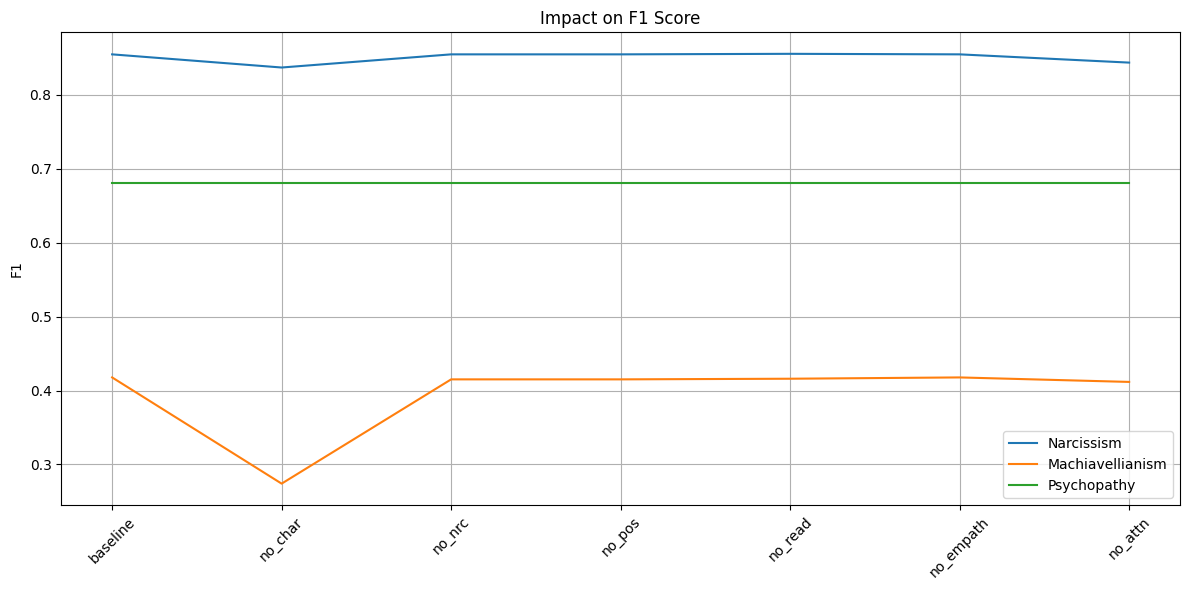

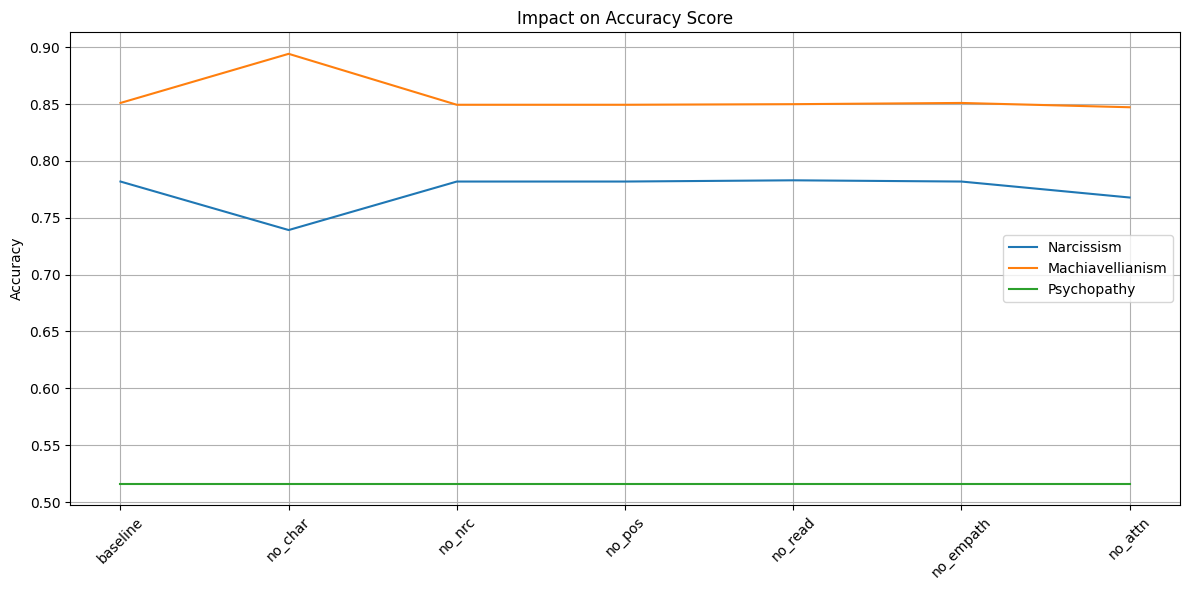

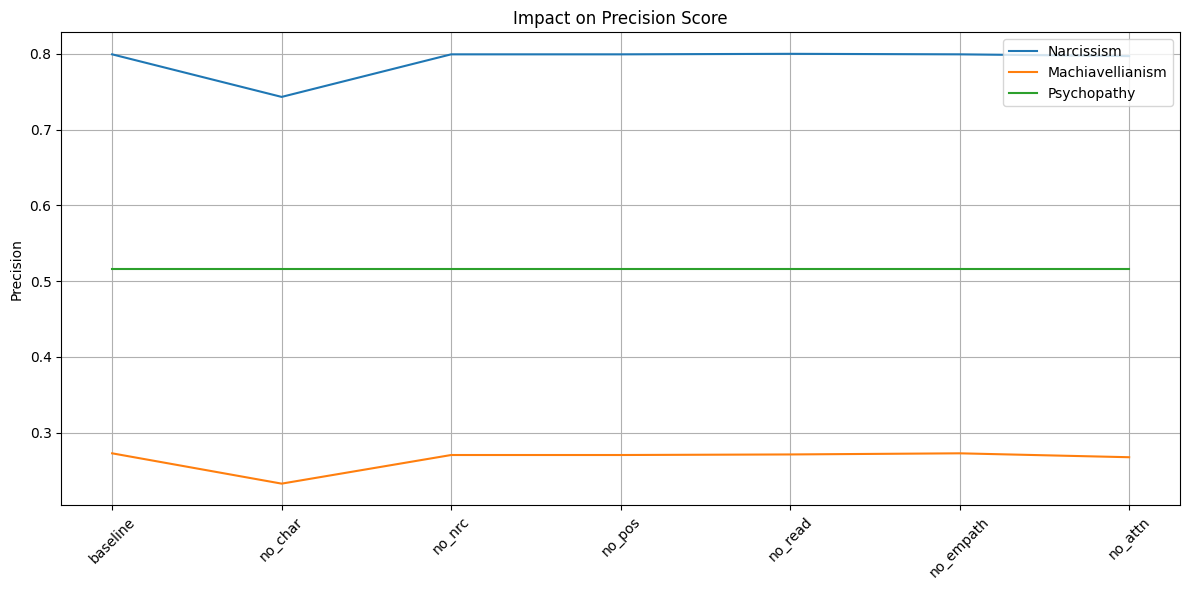

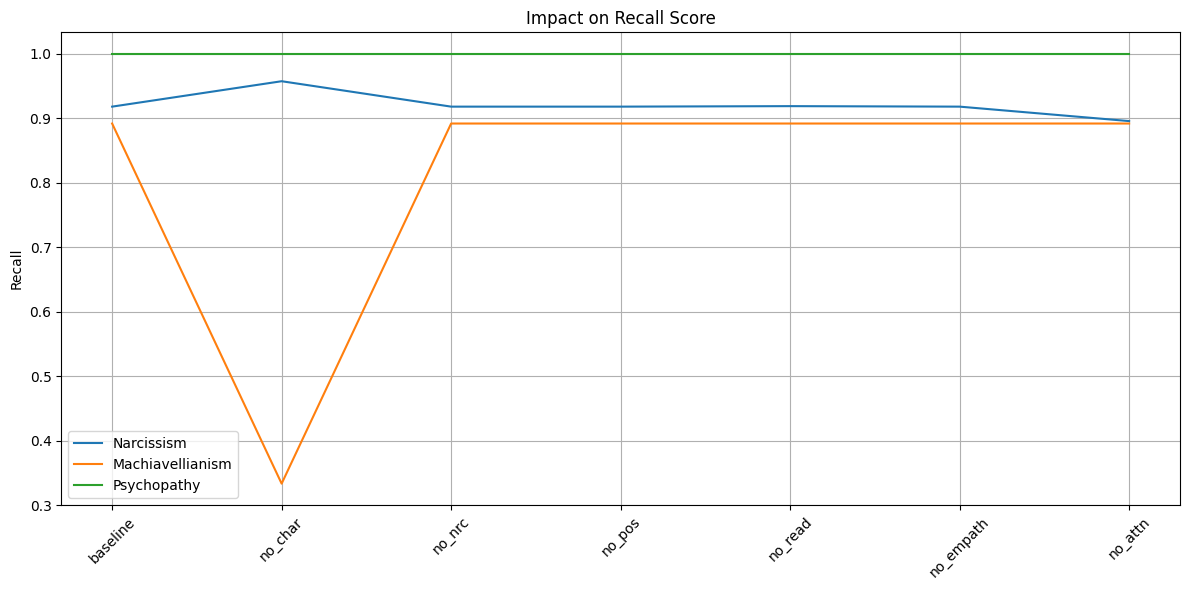

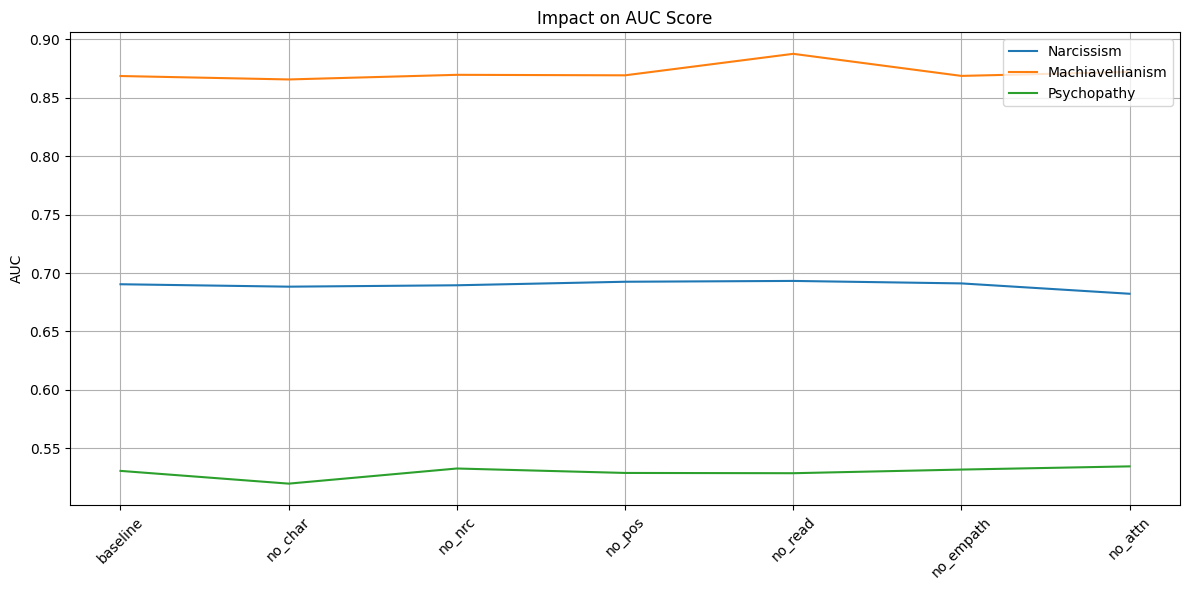


=== Analyzing Attention Patterns ===


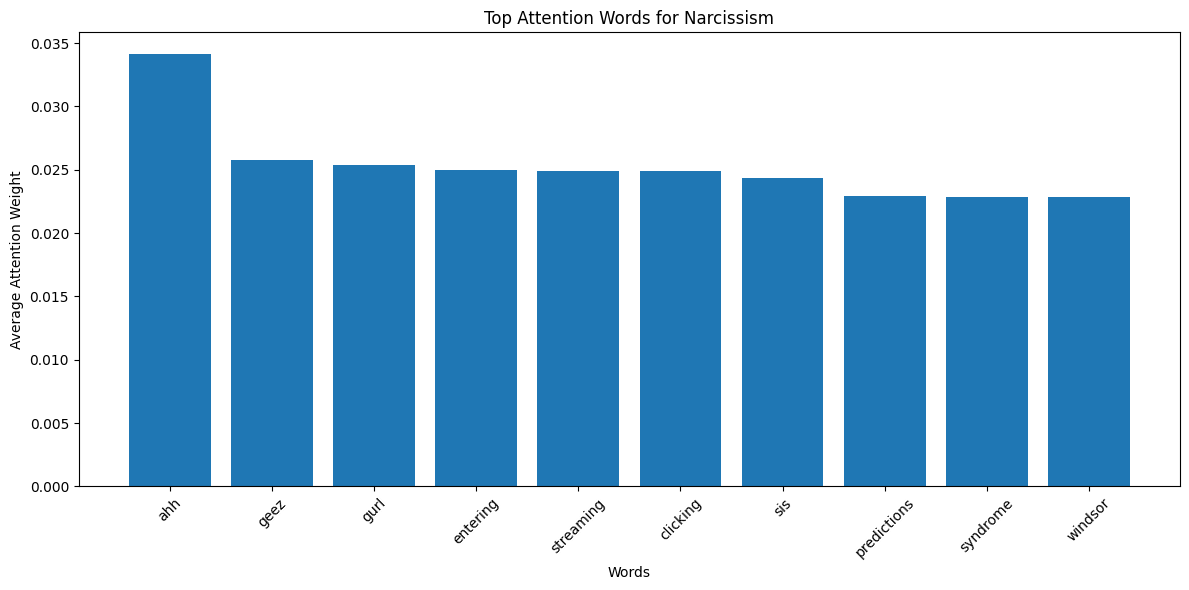


Top 5 words for Narcissism:
  ahh: 0.0341 (appears 1 times)
  geez: 0.0257 (appears 1 times)
  gurl: 0.0254 (appears 1 times)
  entering: 0.0250 (appears 1 times)
  streaming: 0.0249 (appears 1 times)


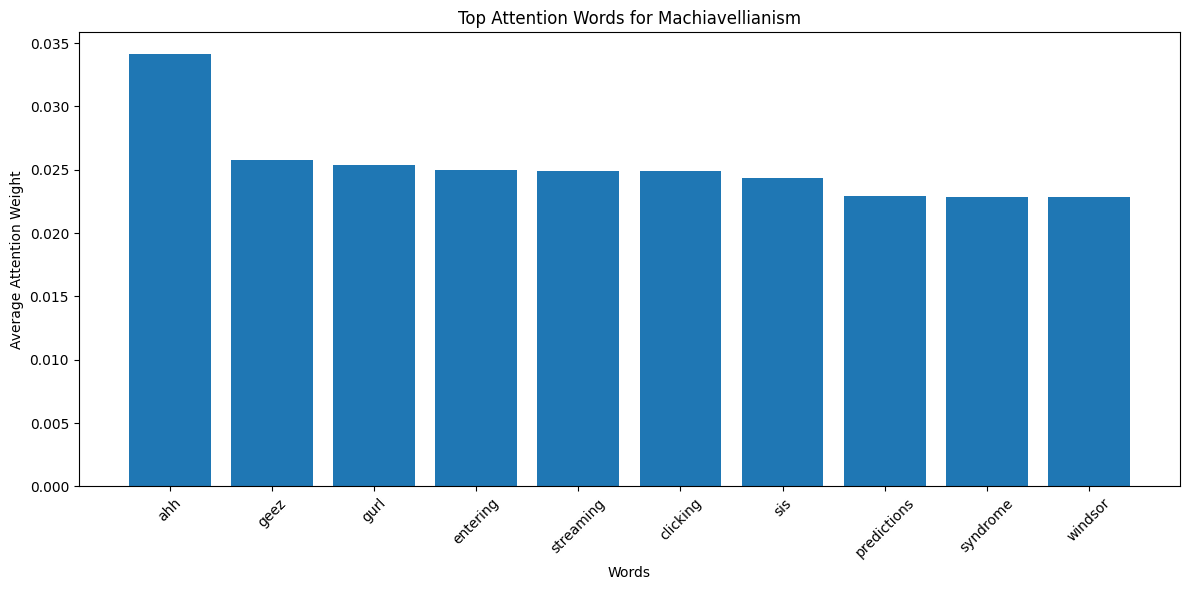


Top 5 words for Machiavellianism:
  ahh: 0.0341 (appears 1 times)
  geez: 0.0257 (appears 1 times)
  gurl: 0.0254 (appears 1 times)
  entering: 0.0250 (appears 1 times)
  streaming: 0.0249 (appears 1 times)


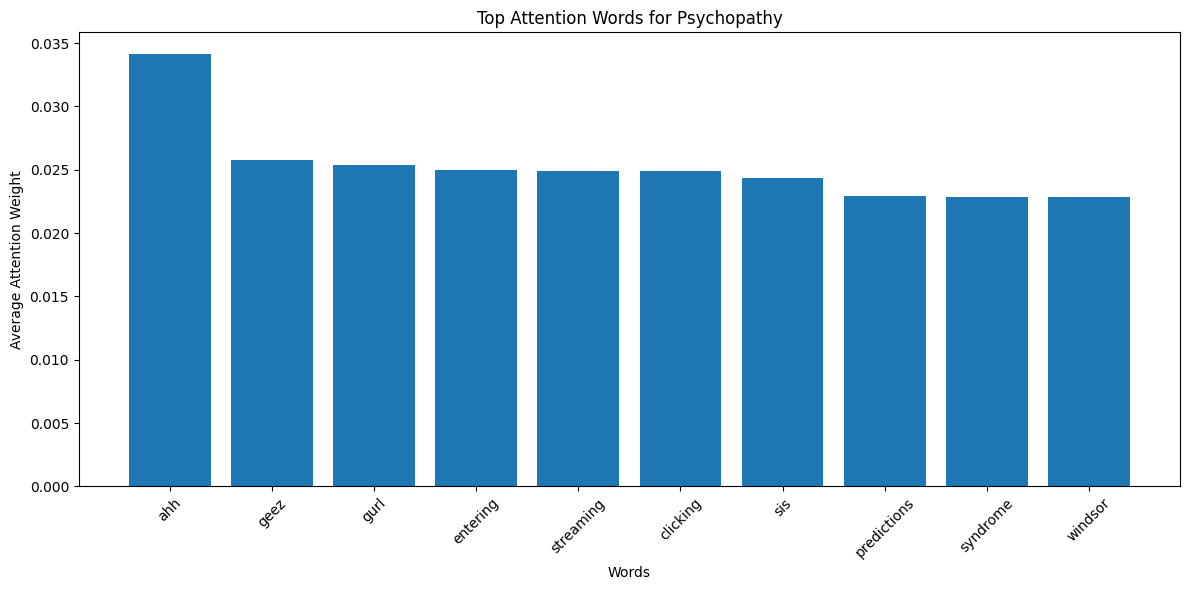


Top 5 words for Psychopathy:
  ahh: 0.0341 (appears 1 times)
  geez: 0.0257 (appears 1 times)
  gurl: 0.0254 (appears 1 times)
  entering: 0.0250 (appears 1 times)
  streaming: 0.0249 (appears 1 times)

=== Visualizing Attention for Sample Text ===
Sample text: the light above my computer is shining so brightly onto the screen the bright light almost blinding as i try not to look straight into it my mind works rapidly as i am trying to focus on my thoughts whenever i actually try to think of something my head seems to go blank and i can think of nothing i guess i don't really think of nothing because the brain is working all the time there is always some sort of idea or made up story in my head when i am alone such as when i walk to class i always daydream about fictional stories or ideal occurrences that i would want to happen in my life then i worry that since i thought of it it would never actually happen like that i do not believe we can predict the future unless dreams are a pred


Predicted probabilities:
Narcissism: 0.3412
Machiavellianism: 0.5105
Psychopathy: 0.5050

=== Generating Visualizations ===


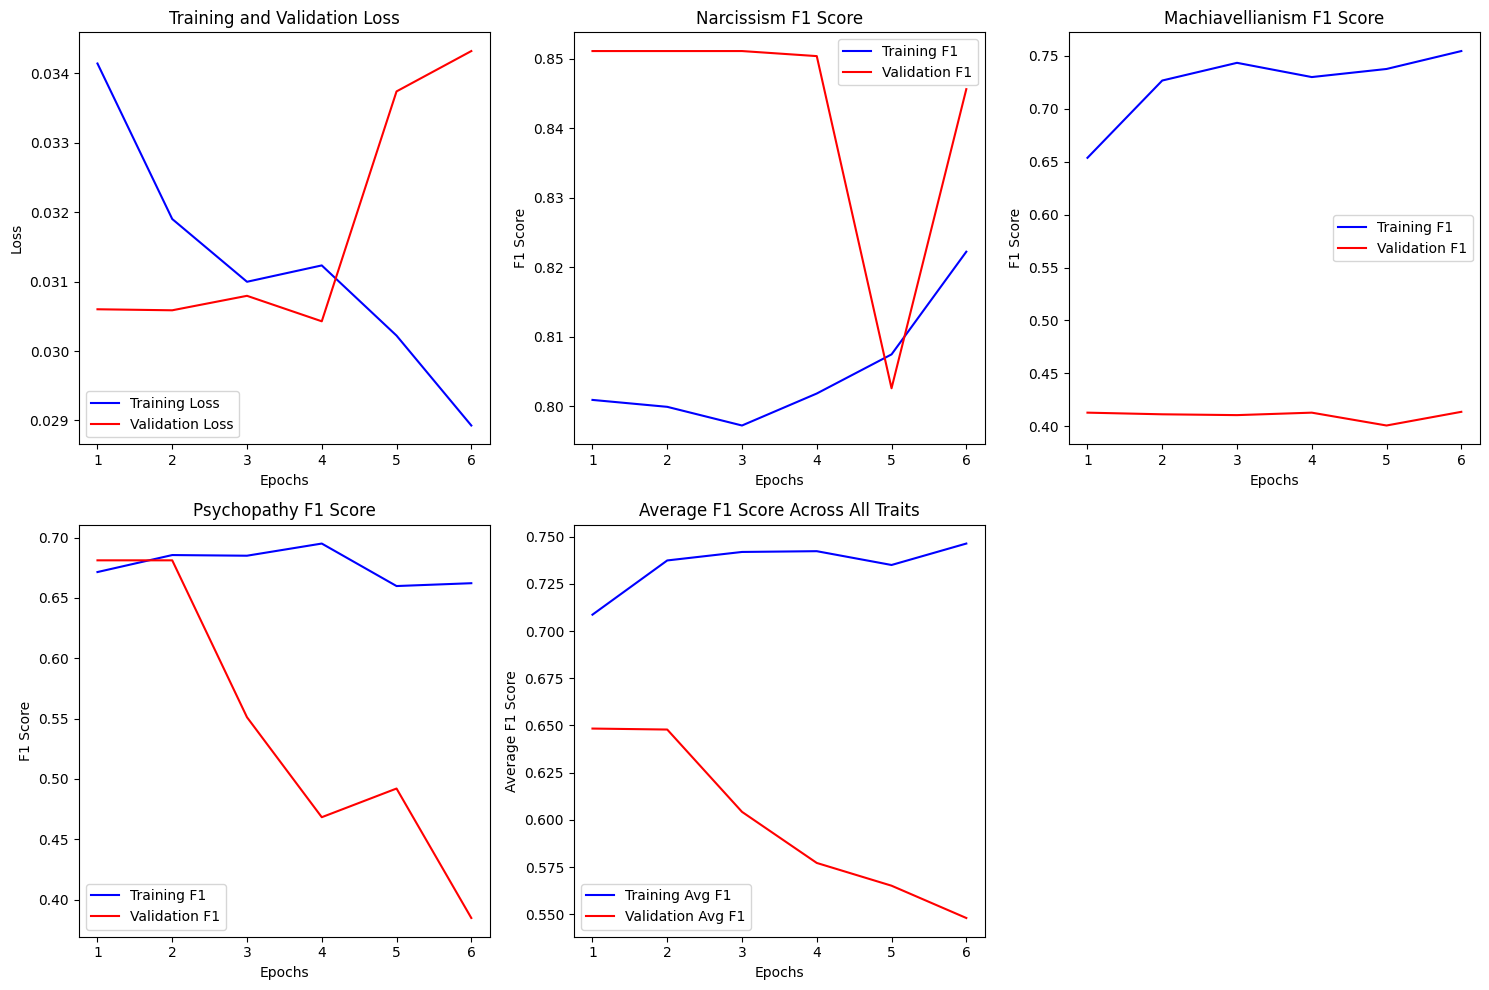

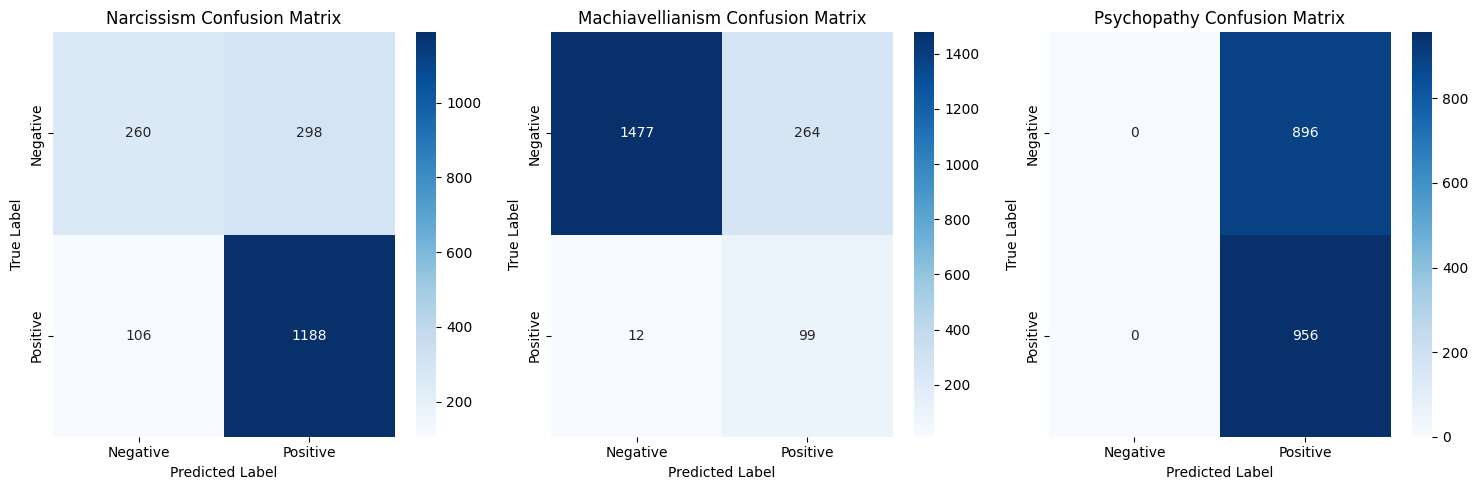

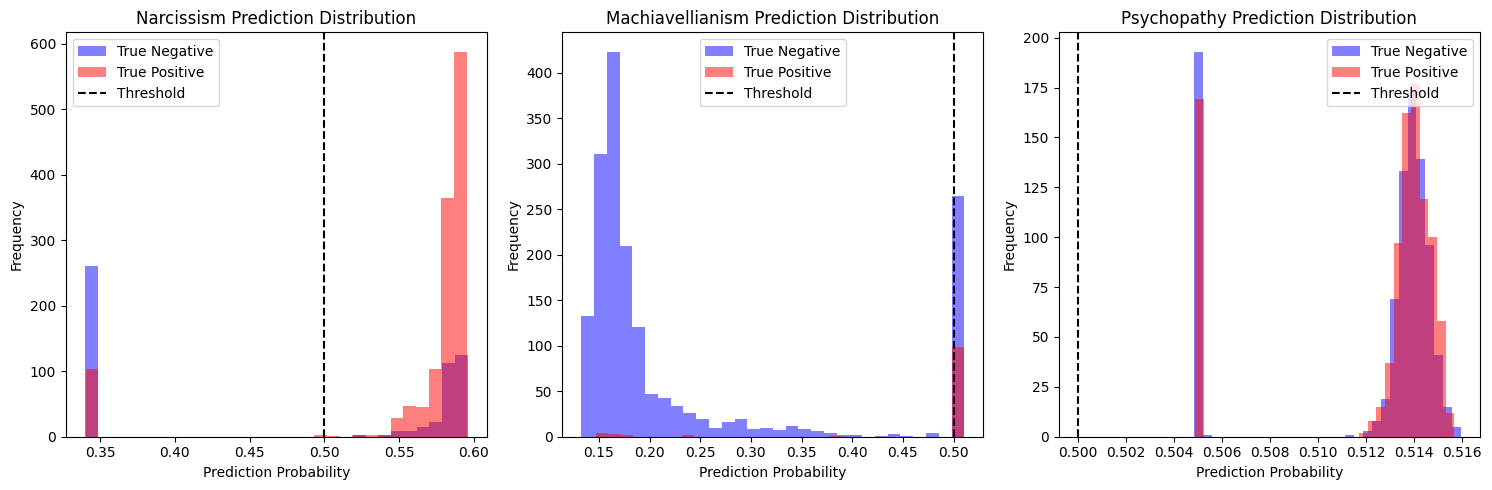

Generating trait-specific attention analysis...
Narcissism: 1294/1852 positive samples (69.9%)
Machiavellianism: 111/1852 positive samples (6.0%)
Psychopathy: 956/1852 positive samples (51.6%)

--- Comprehensive Analysis ---


Comprehensive attention analysis: 100%|██████████| 29/29 [00:20<00:00,  1.45it/s]



Narcissism:
  Positive samples analyzed: 5035
  Unique words with attention >= 2 occurrences: 1754
  Top 5 words: ['ok', 'paying', 'gotten', 'naturally', 'hi']

Machiavellianism:
  Positive samples analyzed: 1801
  Unique words with attention >= 2 occurrences: 760
  Top 5 words: ['hi', 'okay', 'hello', 'geez', 'lunch']

Psychopathy:
  Positive samples analyzed: 4356
  Unique words with attention >= 2 occurrences: 1683
  Top 5 words: ['hello', 'geez', 'jeez', 'presently', 'drugs']

--- Individual Trait Analysis ---

Analyzing attention for Narcissism (1294 positive samples)...


Analyzing Narcissism:   0%|          | 0/29 [00:00<?, ?it/s]


Processed 20 positive samples for Narcissism


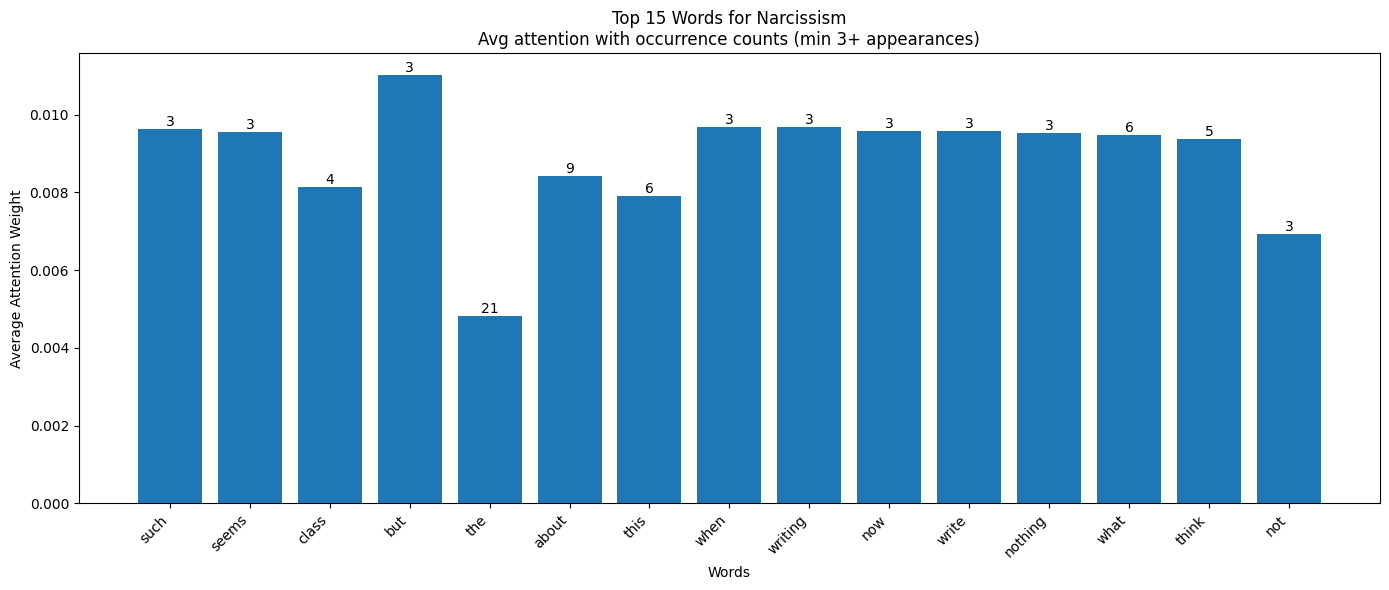


Top attention words for Narcissism:
1. such            - Attn: 0.010 ± 0.000 | Count: 3 | Texts: 3
2. seems           - Attn: 0.010 ± 0.000 | Count: 3 | Texts: 3
3. class           - Attn: 0.008 ± 0.009 | Count: 4 | Texts: 4
4. but             - Attn: 0.011 ± 0.002 | Count: 3 | Texts: 2
5. the             - Attn: 0.005 ± 0.006 | Count: 21 | Texts: 11
6. about           - Attn: 0.008 ± 0.003 | Count: 9 | Texts: 3
7. this            - Attn: 0.008 ± 0.004 | Count: 6 | Texts: 3
8. when            - Attn: 0.010 ± 0.000 | Count: 3 | Texts: 2
9. writing         - Attn: 0.010 ± 0.000 | Count: 3 | Texts: 2
10. now             - Attn: 0.010 ± 0.000 | Count: 3 | Texts: 2
Model and vocabularies saved with prefix: final_enhanced_model
Final model and vocabularies saved successfully.

=== Training Complete ===
Best validation F1 average: 0.6484
Model training and evaluation finished successfully!


Traceback (most recent call last):
  File "/tmp/ipykernel_35/1274468450.py", line 425, in main
    print(f"Top attention words for {trait_name}: {[word for word, _ in top_words[:5]]}")
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_35/1274468450.py", line 425, in <listcomp>
    print(f"Top attention words for {trait_name}: {[word for word, _ in top_words[:5]]}")
                                                             ^^^^^^^
ValueError: too many values to unpack (expected 2)


In [176]:
if __name__ == "__main__":
    main()

Successfully loaded dataset with 12370 samples
Dataset after cleaning: 12346 samples
Class Distribution:
Narcissism: Positive=8623 (0.698), Negative=3723 (0.302)
Machiavellianism: Positive=739 (0.060), Negative=11607 (0.940)
Psychopathy: Positive=6375 (0.516), Negative=5971 (0.484)

Calculating Positive Class Weights (for BCEWithLogitsLoss pos_weight):
Narcissism positive class weight: 0.432
Machiavellianism positive class weight: 15.706
Psychopathy positive class weight: 0.937

Training samples: 8395
Validation samples: 2099
Test samples: 1852

Building vocabularies...
Word vocabulary size: 31345
Character vocabulary size: 40
Loading NRC lexicon...
Successfully loaded NRC lexicon from: /kaggle/input/cs105-final-project-files/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
NRC emotions: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
Number of emotions: 10
Loading GloVe embeddings...
Successfully loaded GloVe embeddings from: /kaggle/

Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s]



Running without character-level features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.51it/s]



Running without NRC features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.50it/s]



Running without POS features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]



Running without readability features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]



Running without Empath features...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]



Running without attention mechanism...


Evaluating: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]



=== Visualizing Ablation Results ===


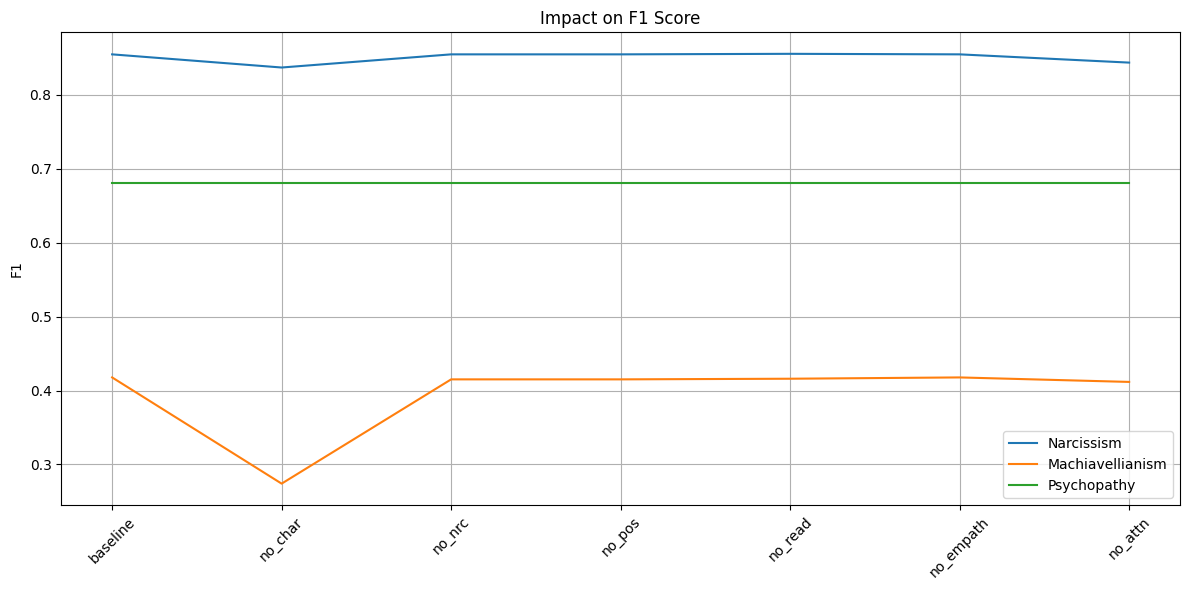

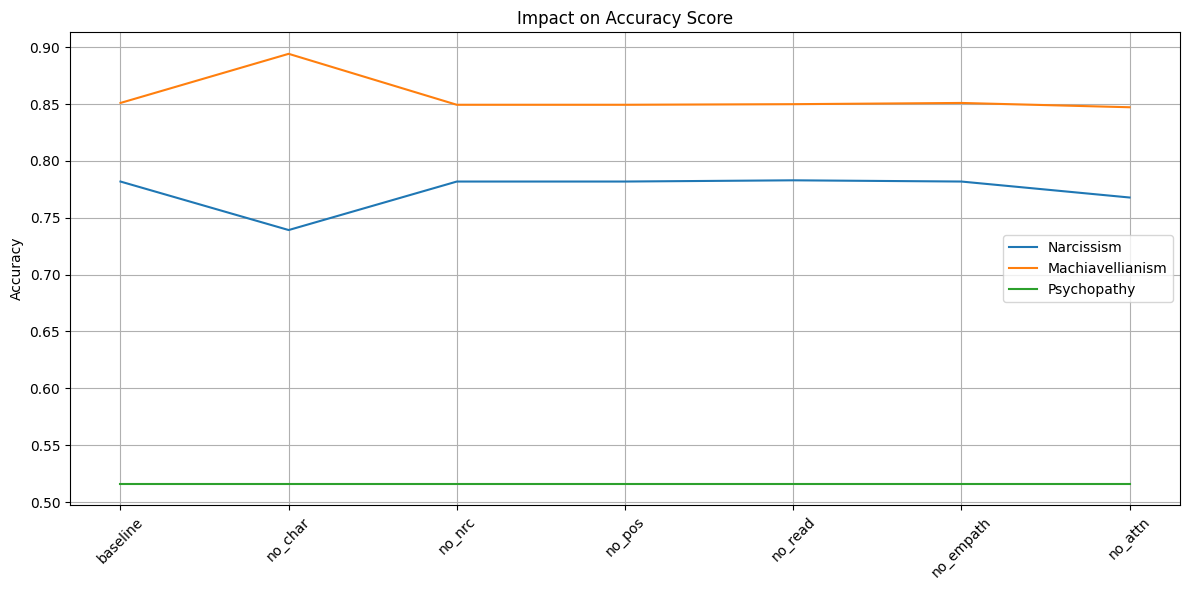

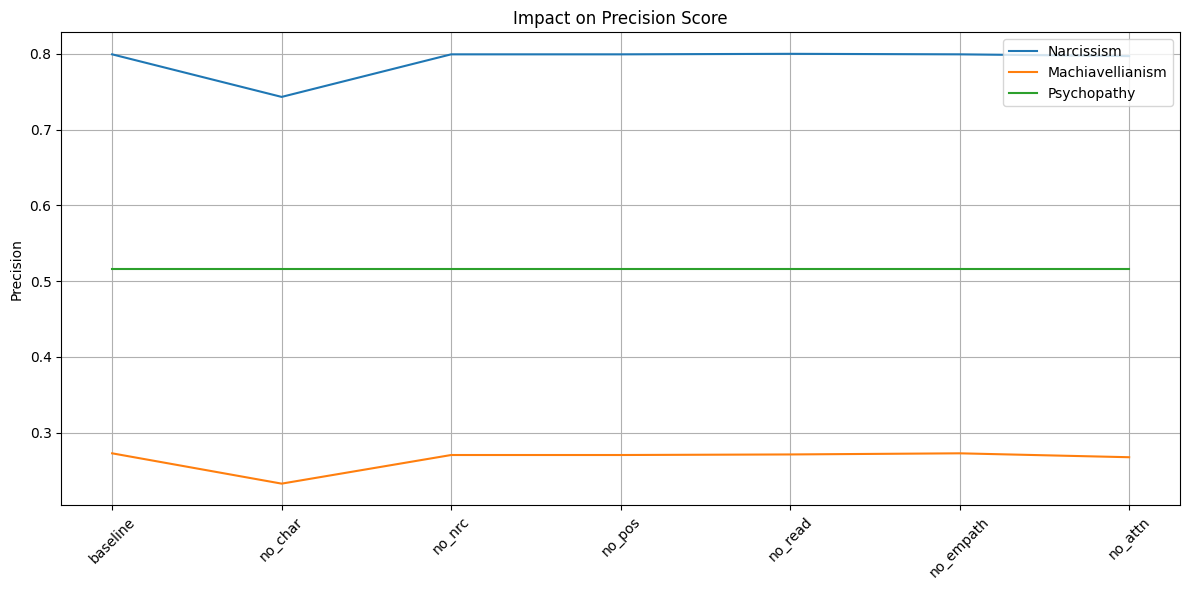

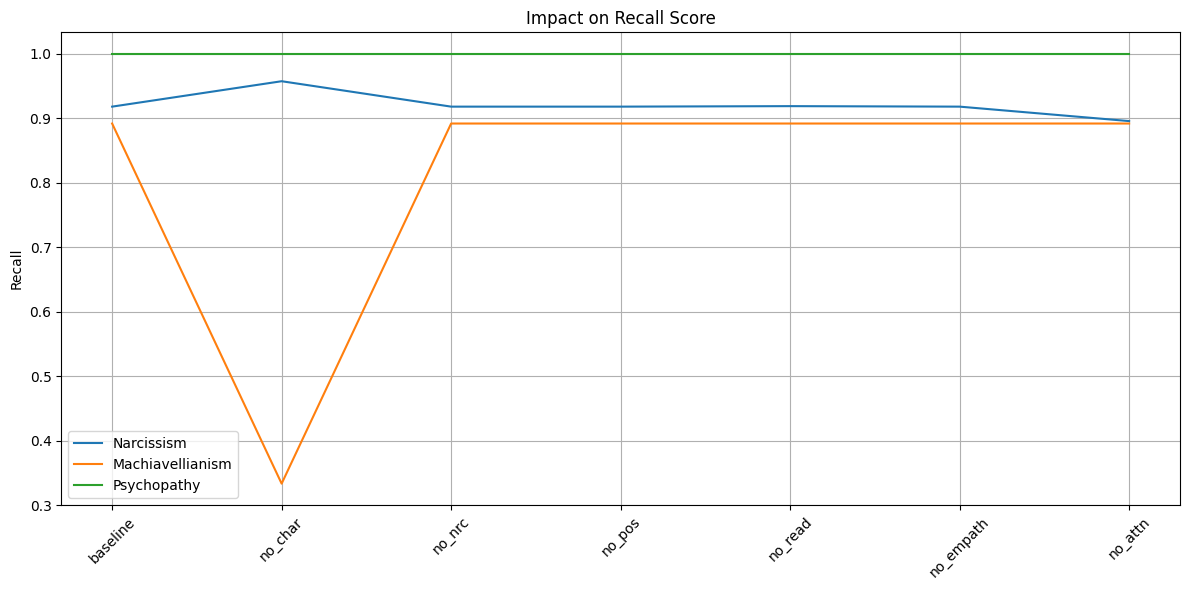

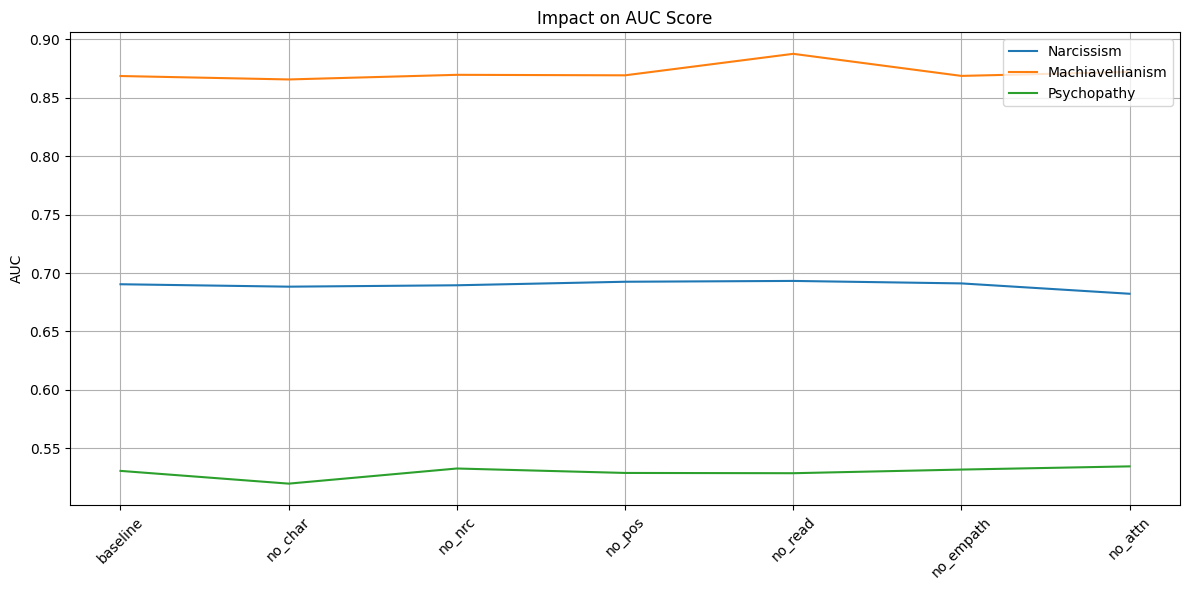

In [177]:
def run_ablation_studies_only(model_path, test_loader, word_vocab, char_vocab, nrc_emotions, device):
    """
    Run ablation studies on a pre-trained model without retraining
    """
    # Load the pre-trained model
    try:
        # First try loading with weights_only=False (only if you trust the source)
        try:
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        except:
            # If that fails, try with weights_only=True and allow numpy scalars
            import numpy.core.multiarray
            torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])
            checkpoint = torch.load(model_path, map_location=device, weights_only=True)
            
        model = DeepPersonDarkTriad(
            word_vocab_size=len(word_vocab),
            word_emb_dim=EMB_DIM,
            char_vocab_size=len(char_vocab),
            char_emb_dim=CHAR_EMB_DIM,
            char_out_channels=CHAR_OUT_CHANNELS,
            hidden_size=HIDDEN_SIZE,
            nrc_token_feat_dim=len(nrc_emotions),
            nrc_token_emb_dim=NRC_TOKEN_EMB_DIM,
            pretrained_word_emb=None,  # Will be loaded from state_dict
            dropout=DROPOUT_RATE
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        print("Successfully loaded pre-trained model")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Use the same criterion as during training
    criterion = FocalLoss(alpha=0.25, gamma=2)
    
    # Run ablation studies
    print("\n=== Running Ablation Studies ===")
    ablation_results = perform_ablation_studies(
        model, test_loader, word_vocab, char_vocab, nrc_emotions, device, criterion
    )
    
    # Visualize results
    print("\n=== Visualizing Ablation Results ===")
    visualize_ablation_results(ablation_results)
    
    return ablation_results


# Example usage:
if __name__ == "__main__":
     # Load dataset with error handling
    try:
        df = pd.read_csv('/kaggle/input/darktriad-dataset/darktriad_dataset.csv')
        print(f"Successfully loaded dataset with {len(df)} samples")
    except FileNotFoundError:
        print("Dataset not found. Using a dummy DataFrame for structure testing.")
        # Create more diverse dummy data for better testing
        data = {
            'STATUS': [
                "I love coding deep learning models and building amazing AI systems.",
                "This is a test status with some emotional content.",
                "Feeling absolutely fantastic today! Life is wonderful and amazing.",
                "Working extremely hard on my challenging project with determination.",
                "Another day, another complex challenge to overcome with brilliance.",
                "Sometimes I feel like I'm the smartest person in the room.",
                "People often don't understand my superior intellect and capabilities.",
                "I manipulate situations to get what I want from others.",
                "Emotions are just tools to be used for personal advantage.",
                "I don't really care about other people's feelings or problems."
            ],
            'Narcissism': [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
            'Machiavellianism': [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            'Psychopathy': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
        }
        df = pd.DataFrame(data)
        print(f"Created dummy dataset with {len(df)} samples")

    # Clean and prepare data
    df['STATUS'] = df['STATUS'].fillna('').astype(str)
    
    # Remove empty statuses
    df = df[df['STATUS'].str.strip() != ''].reset_index(drop=True)
    print(f"Dataset after cleaning: {len(df)} samples")
    
    # Display class distribution
    print_class_distribution(df)
    class_pos_weights_for_bce = calculate_class_weights_for_bce(df)
    
    # Enhanced data splitting with stratification
    stratify_cols = ['Narcissism', 'Machiavellianism', 'Psychopathy']
    can_stratify = True
    
    if not df.empty:
        for col in stratify_cols:
            if col not in df.columns:
                print(f"Warning: Column '{col}' not found in dataset.")
                can_stratify = False
                break
            elif df[col].nunique() < 2 or df[col].value_counts().min() < 2:
                can_stratify = False
                print(f"Warning: Cannot stratify on column '{col}' due to insufficient class members.")
                break

    # Split data into train/validation/test
    if len(df) < 10:
        df_train, df_val, df_test = df, df, df
        print("Warning: Dataset too small, using full dataset for train/val/test.")
    elif can_stratify and len(df) >= 15:
        # First split: train+val vs test
        df_temp, df_test = train_test_split(
            df, test_size=0.15, random_state=42, 
            stratify=df[stratify_cols]
        )
        # Second split: train vs val
        df_train, df_val = train_test_split(
            df_temp, test_size=0.2, random_state=42,
            stratify=df_temp[stratify_cols]
        )
    else:
        # Random split if stratification not possible
        df_temp, df_test = train_test_split(df, test_size=0.15, random_state=42)
        df_train, df_val = train_test_split(df_temp, test_size=0.2, random_state=42)

    print(f"Training samples: {len(df_train)}")
    print(f"Validation samples: {len(df_val)}")
    print(f"Test samples: {len(df_test)}")
    print()
    
    # Build vocabularies
    print("Building vocabularies...")
    word_vocab = build_word_vocab(
        df_train['STATUS'].tolist() if not df_train.empty else [""], 
        min_freq=1  # Lower min_freq for small datasets
    )
    char_vocab = build_char_vocab()
    print(f"Word vocabulary size: {len(word_vocab)}")
    print(f"Character vocabulary size: {len(char_vocab)}")
    
    # Load NRC lexicon
    print("Loading NRC lexicon...")
    nrc_paths = [
        '/kaggle/input/cs105-final-project-files/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
        './NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
        'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
    ]
    
    nrc_lexicon, nrc_emotions = None, None
    for path in nrc_paths:
        try:
            nrc_lexicon, nrc_emotions = load_nrc_lexicon(path)
            print(f"Successfully loaded NRC lexicon from: {path}")
            break
        except FileNotFoundError:
            continue
    
    if nrc_lexicon is None:
        print("NRC Lexicon file not found. Using empty lexicon and default emotions.")
        nrc_lexicon, nrc_emotions = defaultdict(lambda: defaultdict(int)), ['positive', 'negative']
    
    print(f"NRC emotions: {nrc_emotions}")
    print(f"Number of emotions: {len(nrc_emotions)}")

    # Load GloVe embeddings
    print("Loading GloVe embeddings...")
    glove_paths = [
        '/kaggle/input/glove-embeddings/glove.6B.300d.txt',
        './glove.6B.300d.txt',
        'glove.6B.300d.txt'
    ]
    
    pretrained_emb = None
    for path in glove_paths:
        try:
            pretrained_emb = load_glove_embeddings(path, word_vocab, EMB_DIM)
            print(f"Successfully loaded GloVe embeddings from: {path}")
            break
        except FileNotFoundError:
            continue
    
    if pretrained_emb is None:
        print("GloVe file not found. Using random embeddings.")
        pretrained_emb = np.random.normal(size=(len(word_vocab), EMB_DIM)).astype(np.float32)
        if '<PAD>' in word_vocab:
            pretrained_emb[word_vocab['<PAD>']] = np.zeros(EMB_DIM)

    # Create datasets
    print("Creating datasets...")
    train_dataset = DarkTriadDataset(df_train, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    val_dataset = DarkTriadDataset(df_val, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    test_dataset = DarkTriadDataset(df_test, word_vocab, char_vocab, nrc_lexicon, nrc_emotions)
    
    # Create weighted sampler for training
    train_sampler = None
    if not df_train.empty and len(df_train) > 1:
        train_labels_for_sampler = [df_train[trait] for trait in ['Narcissism', 'Machiavellianism', 'Psychopathy']]
        valid_for_sampler = all(len(s) > 0 and s.nunique() > 1 for s in train_labels_for_sampler)
        if valid_for_sampler:
            try:
                train_sampler = create_weighted_sampler(train_labels_for_sampler, BATCH_SIZE)
                print("Created weighted sampler for balanced training")
            except Exception as e:
                print(f"Warning: Could not create weighted sampler: {e}")
        else:
            print("Warning: Could not create weighted sampler due to uniform labels.")

    # Create data loaders
    effective_batch_size = min(BATCH_SIZE, len(train_dataset)) if len(train_dataset) > 0 else 1
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=effective_batch_size, 
        sampler=train_sampler, 
        shuffle=(train_sampler is None),
        drop_last=False
    )
    val_loader = DataLoader(val_dataset, batch_size=effective_batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=False, drop_last=False)
    
    print(f"Data loaders created with batch size: {effective_batch_size}")
    
    ablation_results = run_ablation_studies_only(
        model_path='best_model_enhanced.pt',
        test_loader=test_loader,
        word_vocab=word_vocab,
        char_vocab=char_vocab,
        nrc_emotions=nrc_emotions,
        device=DEVICE
    )